# Diagnosing doctors

In [82]:
from IPython.display import HTML, Image
#HTML('<img src="images/psihiatr_kivaet.gif">')

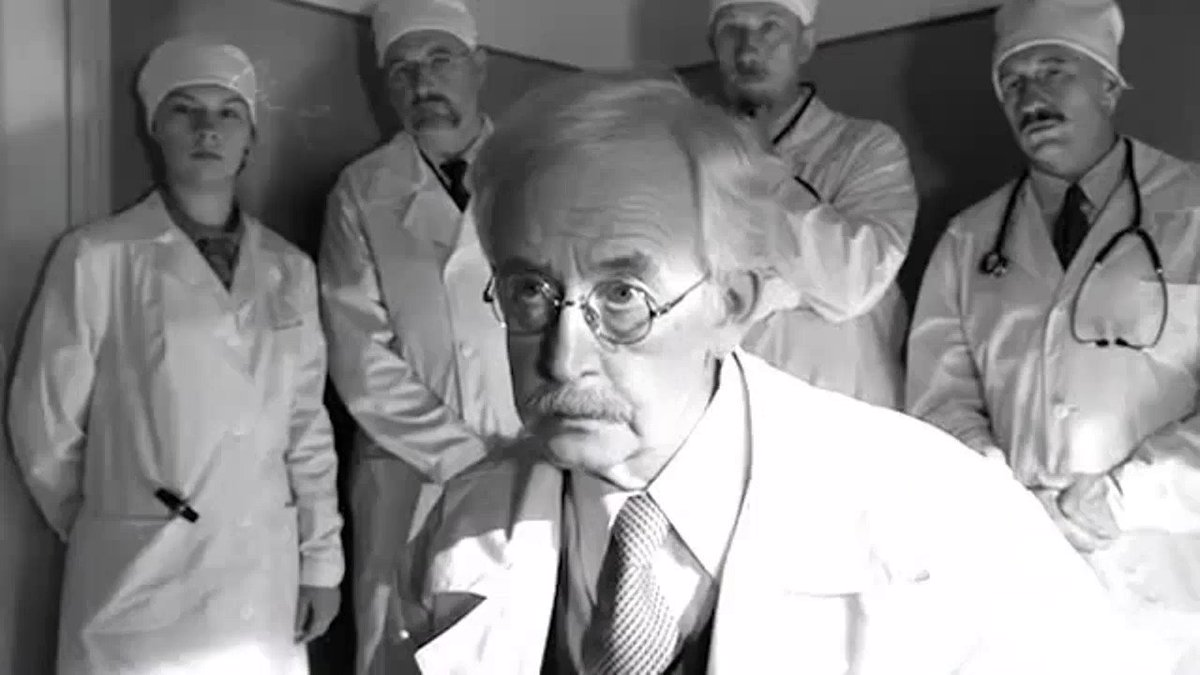

In [2]:
Image(filename='images/psichiatr.jpg', width=600 , height=600 )

<i><b>-- "There are four types of doctors:</b><br>
<b>1) Some can do nothing, but they know everything. These are therapists.</b><br>
<b>2) The second ones do not know anything, but they can do everything. These are surgeons.</b><br>
<b>3) The third ones do not know anything and do not know how. Psychiatrists.</b><br>
<b>4) And there are doctors who know everything and can do everything, but people get to them too late..."</b><br></i>

<i><b> -- "In psychiatry, after all, as - who first put on the robe, he is the doctor."</b></i>

## Recommendations.
<b>1.</b> Increase the amount of doctors in Clusters 0, 10, 22, 28 and 30 for rise the Purchases.<br>
<b>2.</b> Avoid to have a deal with the Cluster 5.<br>
<b>3.</b> Name the Clusters as you wish to labeling them for the intocompany slang.

In [3]:
#dependencies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## 💾 The data

The company stores the information in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

In [4]:
doctors = pd.read_csv('data/doctors.csv')
display(doctors.head(), doctors.shape)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0


(437, 9)

In [5]:
orders = pd.read_csv('data/orders.csv')
display(orders.head(), orders.shape)

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


(257, 12)

In [6]:
complaints = pd.read_csv('data/complaints.csv')
display(complaints.head(), complaints.shape)

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


(435, 3)

In [7]:
instructions = pd.read_csv('data/instructions.csv')
display(instructions.head(), instructions.shape)

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


(77, 2)

## 0. Exploratory Data Analysis.
Looks on what we have.

In [8]:
#data info and missing data detection
print(doctors.isna().sum(), doctors.info())
print(orders.isna().sum(), orders.info())
print(complaints.isna().sum(), complaints.info())
print(instructions.isna().sum(), instructions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence rate  437 non-null    float64
 5   R rate          437 non-null    float64
 6   Satisfaction    437 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    float64
dtypes: float64(4), object(5)
memory usage: 30.9+ KB
DoctorID          0
Region            0
Category          0
Rank              2
Incidence rate    0
R rate            0
Satisfaction      0
Experience        0
Purchases         0
dtype: int64 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
--- 

## 1. How many doctors are there in each region? What is the average number of purchases per region?

#### 1.1. Doctors per region.

Region,1 10,1 10 T3,1 11,1 12,1 12 T3,1 12 T4,1 13,1 13 T3,1 13 T4,1 14,1 14 T3,1 14 T4,1 19,1 19 20,1 19 T3,1 19 T4,1 21 T3,1 21 T4,1 4CP,1 8
DoctorID,15,8,23,23,6,2,34,11,1,32,15,4,31,1,13,9,4,2,1,21


Region,1 8 T3,1 8 T4,1 9,1 9 T3,1 9 T4,17,2 11,2 6 10,2 6 12,2 6 13,2 6 14,2 6 19,2 6 8,2 6 9,2 7 10,2 7 12,2 7 13,2 7 14,2 7 19,2 7 8
DoctorID,14,6,32,11,7,6,9,1,5,6,2,5,4,5,7,6,6,7,14,5


Region,2 7 9,22 18,23 3,3 16,4 15,5 18
DoctorID,8,7,1,1,3,3


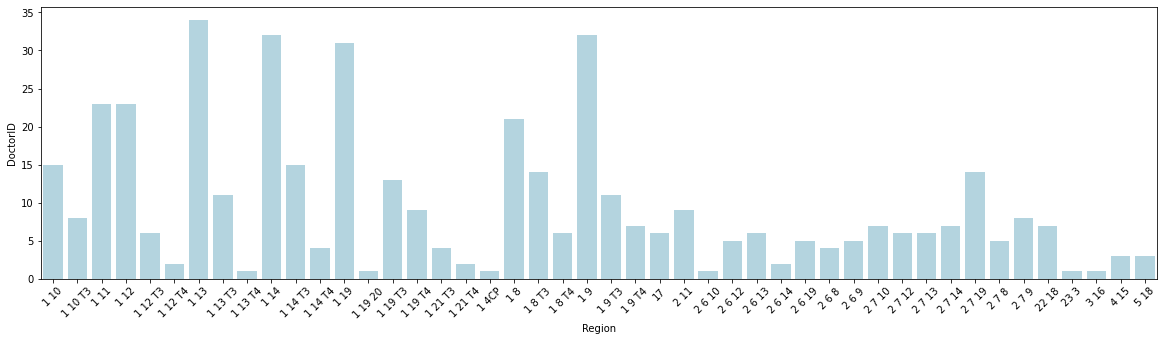

In [9]:
doc_per_reg = doctors.groupby('Region')['DoctorID'].count()
doc_per_reg_df = pd.DataFrame(doc_per_reg)
display(doc_per_reg_df.iloc[0:20, :].T)
display(doc_per_reg_df.iloc[20:40, :].T)
display(doc_per_reg_df.iloc[40:, :].T)

doc_per_reg_df = doc_per_reg_df.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(data=doc_per_reg_df, y='DoctorID', x='Region', color='lightblue')
plt.xticks(rotation=45)
plt.show()

#### 1.2 Average number of purchases per region.

Region,1 10,1 10 T3,1 11,1 12,1 12 T3,1 12 T4,1 13,1 13 T3,1 13 T4,1 14,1 14 T3,1 14 T4,1 19,1 19 20,1 19 T3,1 19 T4,1 21 T3,1 21 T4,1 4CP,1 8
Purchases,15.0,11.375,10.565217,14.913043,14.833333,22.5,10.382353,9.909091,30.0,12.15625,11.666667,19.5,9.064516,129.0,10.769231,25.333333,8.75,11.0,6.0,10.809524


Region,1 8 T3,1 8 T4,1 9,1 9 T3,1 9 T4,17,2 11,2 6 10,2 6 12,2 6 13,2 6 14,2 6 19,2 6 8,2 6 9,2 7 10,2 7 12,2 7 13,2 7 14,2 7 19,2 7 8
Purchases,10.928571,18.5,10.8125,7.636364,23.428571,4.5,5.666667,5.0,3.8,4.5,3.0,3.6,4.25,5.2,5.142857,6.166667,7.666667,3.571429,4.785714,4.6


Region,2 7 9,22 18,23 3,3 16,4 15,5 18
Purchases,4.125,6.285714,14.0,14.0,23.333333,5.0


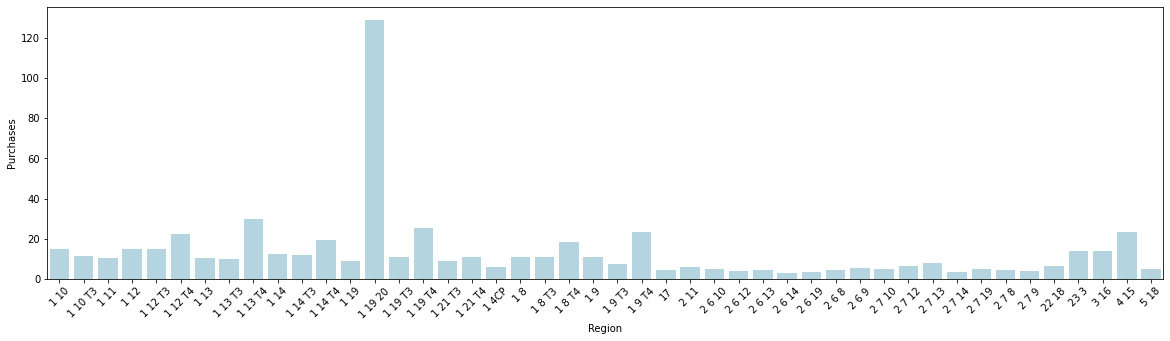

In [10]:
avg_purch_reg = doctors.groupby('Region')['Purchases'].mean()
avg_purch_reg_df = pd.DataFrame(avg_purch_reg)
display(avg_purch_reg_df.iloc[0:20, :].T)
display(avg_purch_reg_df.iloc[20:40, :].T)
display(avg_purch_reg_df.iloc[40:, :].T)

avg_purch_reg_df = avg_purch_reg_df.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(data=avg_purch_reg_df, y='Purchases', x='Region', color='lightblue')
plt.xticks(rotation=45)
plt.show()

## 2. Can you find a relationship between purchases and complaints?

In [11]:
df_purch_compl = doctors.merge(complaints, how='left', on='DoctorID')[['Purchases', 'Complaint Type']]
df_purch_compl = df_purch_compl.dropna().reset_index(drop=True)
display(df_purch_compl.head())
print("Count:")
print(df_purch_compl.count())
print("\nComplaint Type value count:")
print(df_purch_compl['Complaint Type'].value_counts())
print("\nMissing data:", df_purch_compl['Complaint Type'].isna().sum())

,Purchases,Complaint Type
0,14.0,Unknown
1,14.0,Correct
2,13.0,Correct
3,13.0,Incorrect
4,13.0,Unknown


Count:
Purchases         125
Complaint Type    125
dtype: int64

Complaint Type value count:
Correct      55
Incorrect    35
Unknown      31
Specific      3
R&R           1
Name: Complaint Type, dtype: int64

Missing data: 0


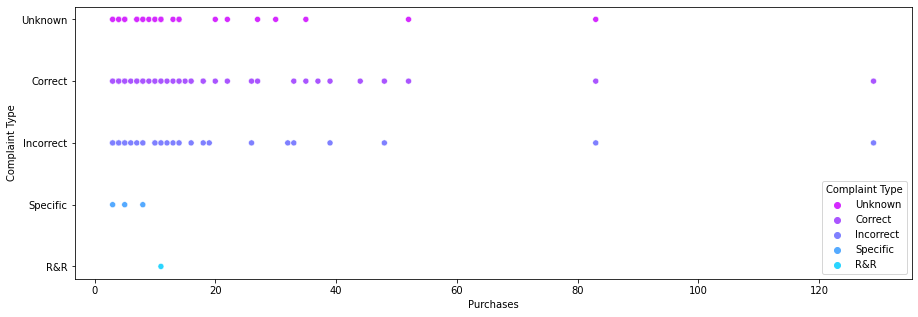

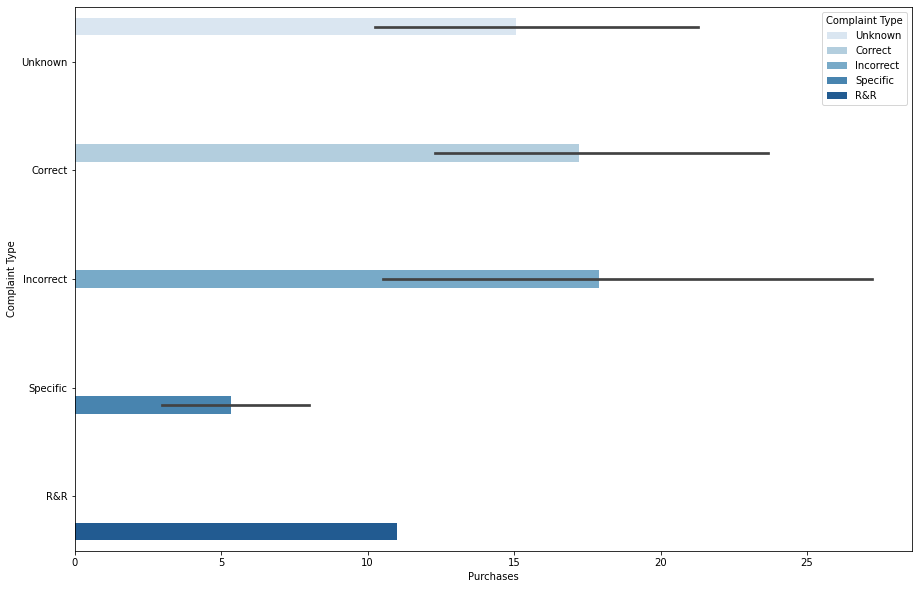

In [12]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_purch_compl, x='Purchases', y='Complaint Type', hue='Complaint Type', palette='cool_r')
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(data=df_purch_compl, x='Purchases', y='Complaint Type', hue='Complaint Type', palette='Blues')
plt.show()

## 3. Define new doctor segments that help the company improve marketing efforts and customer service.

#### 3.1. Unification data in a single dataframe.

In [13]:
df_unite = doctors.merge(orders, how='left', on='DoctorID').merge(complaints, how='left', on='DoctorID').merge(instructions, how='left', on='DoctorID')
display(df_unite)
print('\n Columns:\n', df_unite.columns)
print('\nMissed data:'), print(df_unite.isna().sum())
display(df_unite.shape)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,OrderID,...,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Qty,Instructions
0,AHDCBA,4 15,Specialist,Ambassador,49.00,0.90,53.85,1.20,49.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.00,0.00,100.00,0.00,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.00,1.53,--,0.00,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.00,2.03,--,0.48,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FJBEA,1 14 T4,Specialist,Ambassador,23.00,0.96,76.79,0.75,24.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,BBAJCF,1 9 T4,Specialist,Ambassador,2.17,1.68,--,0.11,19.0,DGBBFIC,...,False,False,False,False,True,False,NaN,Incorrect,1.0,NaN
782,BBAJCF,1 9 T4,Specialist,Ambassador,2.17,1.68,--,0.11,19.0,DGEADDG,...,False,False,False,False,False,False,NaN,Incorrect,1.0,NaN
783,GGCFB,1 19 T4,Specialist,Ambassador,2.14,0.77,--,0.27,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
784,FDCEG,1 9,Specialist,Ambassador,2.13,0.84,100.00,0.32,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 Columns:
 Index(['DoctorID', 'Region', 'Category', 'Rank', 'Incidence rate', 'R rate',
       'Satisfaction', 'Experience', 'Purchases', 'OrderID', 'OrderNum',
       'Condition A', 'Condition B', 'Condition C', 'Condition D',
       'Condition F', 'Condition G', 'Condition H', 'Condition I',
       'Condition J', 'Complaint Type', 'Qty', 'Instructions'],
      dtype='object')

Missed data:
DoctorID            0
Region              0
Category            0
Rank                2
Incidence rate      0
R rate              0
Satisfaction        0
Experience          0
Purchases           0
OrderID           363
OrderNum          363
Condition A       363
Condition B       363
Condition C       374
Condition D       363
Condition F       367
Condition G       367
Condition H       363
Condition I       363
Condition J       549
Complaint Type    363
Qty               363
Instructions      619
dtype: int64


(786, 23)

#### 3.2. Splitting data for numeric and non-numeric for endocing

In [14]:
displ_df_unite = pd.DataFrame(df_unite.dtypes).T
display(displ_df_unite)

df_obj = df_unite.drop(['Incidence rate', 'R rate', 'Experience', 'Purchases', 'Qty'], axis=1)
df_float = df_unite[['Incidence rate', 'R rate', 'Experience', 'Purchases', 'Qty']]
displ_df_obj = pd.DataFrame(df_obj.dtypes).T
display(displ_df_obj)
displ_df_float = pd.DataFrame(df_float.dtypes).T
display(displ_df_float)

df_float_filled = df_float.fillna(0)
display(df_float_filled.head())

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,OrderID,...,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Qty,Instructions
0,object,object,object,object,float64,float64,object,float64,float64,object,...,object,object,object,object,object,object,object,object,float64,object


,DoctorID,Region,Category,Rank,Satisfaction,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Instructions
0,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object


,Incidence rate,R rate,Experience,Purchases,Qty
0,float64,float64,float64,float64,float64


,Incidence rate,R rate,Experience,Purchases,Qty
0,49.0,0.90,1.20,49.0,0.0
1,37.0,0.00,0.00,38.0,0.0
2,33.0,1.53,0.00,34.0,0.0
3,28.0,2.03,0.48,29.0,0.0
4,23.0,0.96,0.75,24.0,0.0


#### 3.3. Getting dummies for Complaint Type.

In [15]:
dummies_complaint = pd.get_dummies(df_unite['Complaint Type'])
display(dummies_complaint)
df_obj_no_co = df_obj.drop('Complaint Type', axis=1)
df_num_co_dum = pd.concat([df_float_filled, dummies_complaint], axis=1)

,Correct,Incorrect,R&R,Specific,Unknown
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
781,0,1,0,0,0
782,0,1,0,0,0
783,0,0,0,0,0
784,0,0,0,0,0


#### 3.4. Encoding non-numeric data by LabelEncoder.

In [16]:
display(df_obj_no_co)

#LabelEncoder

le = LabelEncoder()

df_temp = pd.DataFrame()
for column in df_obj_no_co:
    col = df_obj_no_co[column]
    col_enc = pd.DataFrame(le.fit_transform(col))
    df_temp = df_temp.append(col_enc.T)

df_tempT = df_temp.T
df_tempT.columns = df_obj_no_co.columns    
display(df_tempT)

df_enc = pd.concat([df_tempT, df_num_co_dum], axis=1)
display(df_enc.head(), df_enc.shape)

,DoctorID,Region,Category,Rank,Satisfaction,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Instructions
0,AHDCBA,4 15,Specialist,Ambassador,53.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FDHFJ,1 9 T4,Specialist,Ambassador,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BJJHCA,1 10 T3,Specialist,Ambassador,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FJBEA,1 14 T4,Specialist,Ambassador,76.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,BBAJCF,1 9 T4,Specialist,Ambassador,--,DGBBFIC,AFDFJID,False,False,False,False,False,False,True,False,NaN,NaN
782,BBAJCF,1 9 T4,Specialist,Ambassador,--,DGEADDG,AFAAECG,False,False,False,False,False,False,False,False,NaN,NaN
783,GGCFB,1 19 T4,Specialist,Ambassador,--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
784,FDCEG,1 9,Specialist,Ambassador,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,DoctorID,Region,Category,Rank,Satisfaction,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Instructions
0,109,44,1,0,61,239,238,2,2,2,2,2,2,2,2,2,1
1,30,21,0,0,28,239,238,2,2,2,2,2,2,2,2,2,2
2,341,24,1,0,0,239,238,2,2,2,2,2,2,2,2,2,2
3,212,1,1,0,0,239,238,2,2,2,2,2,2,2,2,2,2
4,349,11,1,0,81,239,238,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,162,24,1,0,0,71,80,0,0,0,0,0,0,1,0,2,2
782,162,24,1,0,0,146,70,0,0,0,0,0,0,0,0,2,2
783,379,15,1,0,0,239,238,2,2,2,2,2,2,2,2,2,1
784,326,22,1,0,28,239,238,2,2,2,2,2,2,2,2,2,2


,DoctorID,Region,Category,Rank,Satisfaction,OrderID,OrderNum,Condition A,Condition B,Condition C,...,Incidence rate,R rate,Experience,Purchases,Qty,Correct,Incorrect,R&R,Specific,Unknown
0,109,44,1,0,61,239,238,2,2,2,...,49.0,0.90,1.20,49.0,0.0,0,0,0,0,0
1,30,21,0,0,28,239,238,2,2,2,...,37.0,0.00,0.00,38.0,0.0,0,0,0,0,0
2,341,24,1,0,0,239,238,2,2,2,...,33.0,1.53,0.00,34.0,0.0,0,0,0,0,0
3,212,1,1,0,0,239,238,2,2,2,...,28.0,2.03,0.48,29.0,0.0,0,0,0,0,0
4,349,11,1,0,81,239,238,2,2,2,...,23.0,0.96,0.75,24.0,0.0,0,0,0,0,0


(786, 27)

#### 3.4.1. Changing the Encoded Condition columns the 'True' value

In [17]:
cond_repl = ['Condition A','Condition B','Condition C','Condition D','Condition F','Condition G','Condition H','Condition I','Condition J']
df_enc[cond_repl] = df_enc[cond_repl].replace(1, 4)
display(df_enc[cond_repl].tail())

,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
781,0,0,0,0,0,0,4,0,2
782,0,0,0,0,0,0,0,0,2
783,2,2,2,2,2,2,2,2,2
784,2,2,2,2,2,2,2,2,2
785,2,2,2,2,2,2,2,2,2


#### 3.5. KMeans clustering.

In [18]:
WCSS = []
for i in range(5,80):
    model = KMeans(n_clusters = i,random_state=123).fit(df_enc)
    WCSS.append(model.inertia_)

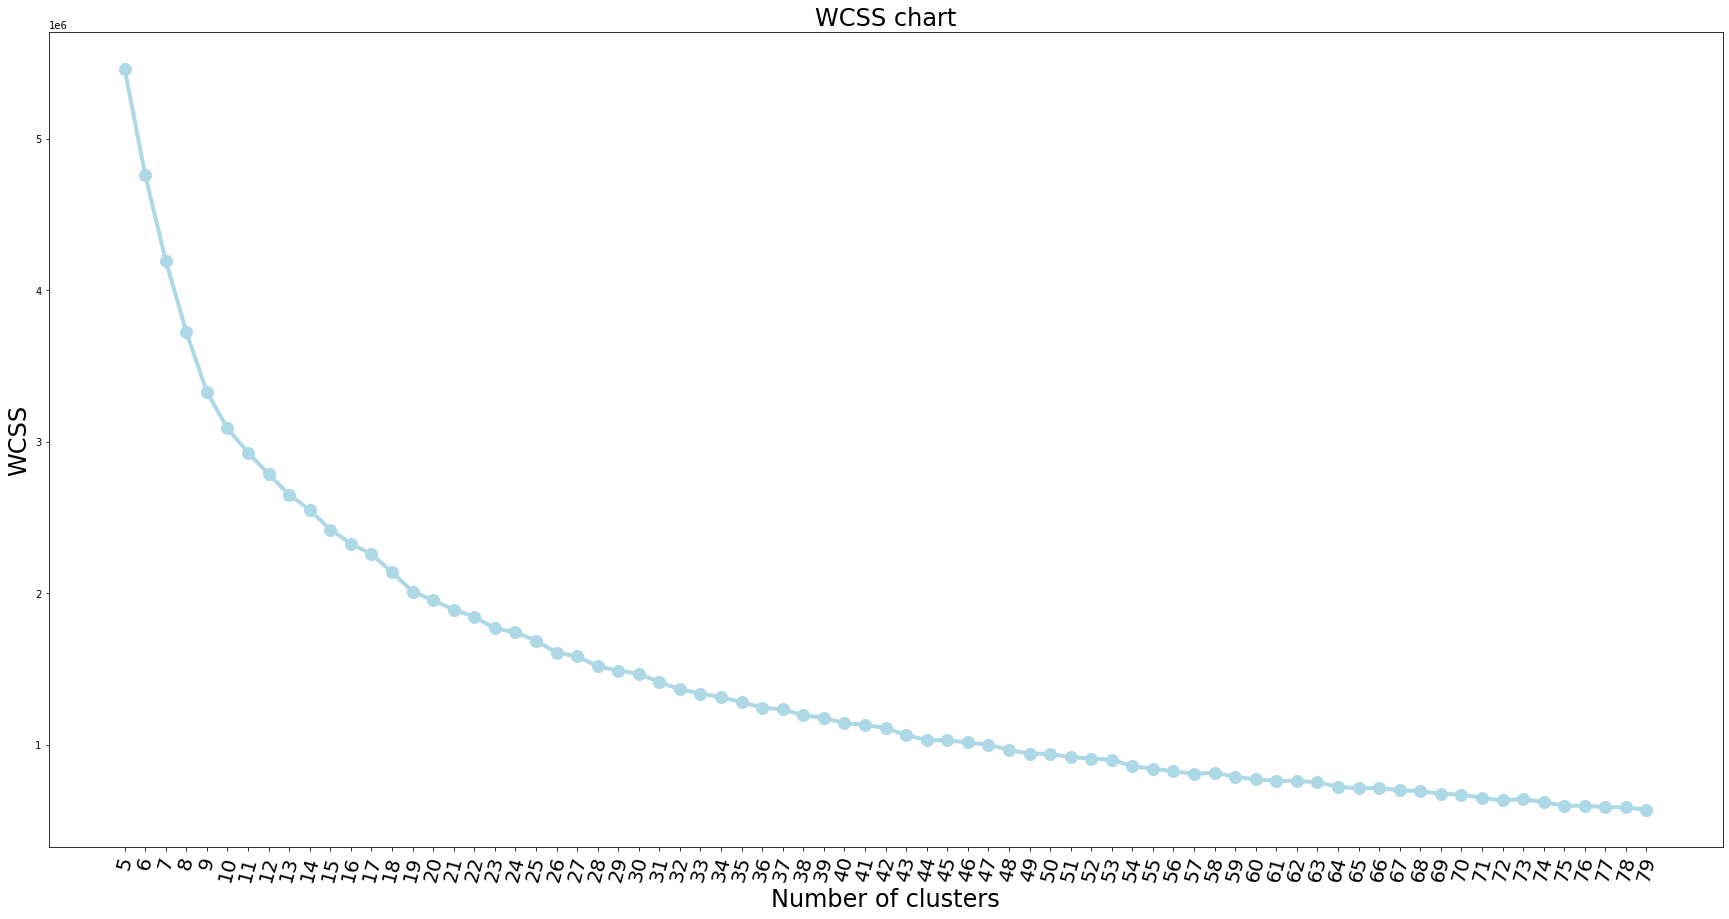

In [19]:
fig = plt.figure(figsize = (30,15))
plt.plot(range(5,80),WCSS, linewidth=4, markersize=12,marker='o',color = 'lightblue')
plt.xticks(np.arange(5, 80), rotation=75, fontsize=20)
plt.title("WCSS chart", fontsize=24)
plt.xlabel("Number of clusters", fontsize=24)
plt.ylabel("WCSS", fontsize=24)
plt.show()

Elbow should be somewhere between 15 and 35

In [20]:
silh_score_temp = []
db_score_temp = []
km_labels_temp = pd.DataFrame()
for i in range (15, 36):
    km_labels=KMeans(n_clusters=i,random_state=123).fit_predict(df_enc)
    km_labels_df=pd.DataFrame(km_labels)
    km_labels_temp = km_labels_temp.append(km_labels_df.T)
    silh_score = silhouette_score(df_enc,km_labels, metric='euclidean').round(3)
    silh_score_temp.append([i, silh_score])
    db_score = davies_bouldin_score(df_enc,km_labels).round(3)
    db_score_temp.append([i, db_score])

In [21]:
print(silh_score_temp)
print("Best Silhouette score is: {}".format(np.amax(silh_score_temp, axis=0)[1]))
print("\n")
print(db_score_temp)
print("Best Davies Bouldin Score: {}".format(np.amin(db_score_temp, axis=0)[1]))

[[15, 0.314], [16, 0.309], [17, 0.326], [18, 0.297], [19, 0.325], [20, 0.309], [21, 0.306], [22, 0.287], [23, 0.318], [24, 0.291], [25, 0.295], [26, 0.311], [27, 0.303], [28, 0.318], [29, 0.332], [30, 0.325], [31, 0.337], [32, 0.315], [33, 0.318], [34, 0.314], [35, 0.322]]
Best Silhouette score is: 0.337


[[15, 1.049], [16, 1.081], [17, 1.007], [18, 1.065], [19, 1.029], [20, 1.084], [21, 1.122], [22, 1.118], [23, 1.08], [24, 1.117], [25, 1.119], [26, 1.088], [27, 1.097], [28, 1.077], [29, 1.037], [30, 1.07], [31, 1.008], [32, 1.05], [33, 1.067], [34, 1.009], [35, 1.011]]
Best Davies Bouldin Score: 1.007


This Data confuses me. From the shown above 80 clusters variation, I decided to use 31 clusters by the dwarven elbow rule:

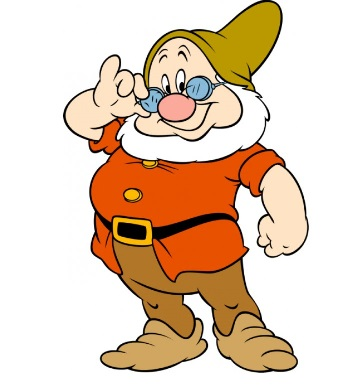

In [22]:
Image(filename='images/dwarfelbow.jpg', width=200 , height=200 )

In [23]:
km_labels=km_labels_temp.iloc[16, :]
print("Silhouette score for clusters k-means : {} ".format(silhouette_score(df_enc,km_labels, metric='euclidean').round(3)))
print('Davies Bouldin Score:'+str(davies_bouldin_score(df_enc,km_labels).round(3)))
kmeans_labels = km_labels

Silhouette score for clusters k-means : 0.337 
Davies Bouldin Score:1.008


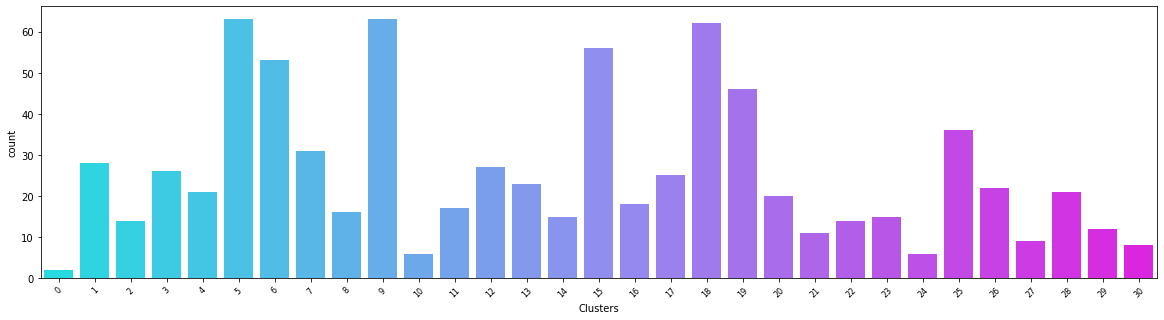

In [24]:
fig = plt.figure(figsize=(20,5))
sns.countplot(kmeans_labels, palette='cool')
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('Clusters')
plt.show()

## 4. Identify which features impact the new segmentation strategy the most.

#### 4.1. Observing the clusters data.

In [25]:
df_enc['Clusters'] = pd.Series(kmeans_labels, index=df_enc.index)
df_unite['Clusters'] = pd.Series(kmeans_labels, index=df_unite.index)
display(df_unite.head())

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,OrderID,...,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Qty,Instructions,Clusters
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,15
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


In [26]:
grouped_clusters_avg = df_enc.groupby('Clusters').mean().round(2).reset_index()
display(grouped_clusters_avg.set_index('Clusters').T)

Clusters,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
DoctorID,425.00,257.25,257.43,13.77,349.43,167.90,403.19,143.74,265.38,34.30,...,253.55,362.21,150.67,68.00,267.58,115.23,325.44,369.14,174.25,271.12
Region,13.00,14.00,10.71,16.77,11.19,18.51,16.23,12.16,14.38,18.35,...,4.36,8.21,8.67,15.50,15.97,12.23,21.33,8.10,22.33,7.50
Category,1.00,0.96,1.00,0.92,1.00,0.67,0.98,1.00,0.94,0.67,...,1.00,1.00,0.93,1.00,1.00,0.95,1.00,1.00,0.50,1.00
Rank,0.00,3.07,2.71,2.69,4.90,3.32,2.77,3.52,1.31,2.92,...,1.00,1.00,2.27,2.00,0.89,5.55,2.11,1.48,2.58,1.12
Satisfaction,85.00,72.43,15.71,18.81,12.67,9.78,12.77,2.71,27.56,22.13,...,41.82,47.43,17.60,49.50,18.33,0.91,18.67,22.05,17.33,44.50
OrderID,28.00,235.00,94.36,116.42,61.71,237.44,238.13,143.68,191.62,234.22,...,58.64,92.43,27.67,59.83,21.86,180.59,42.78,145.38,124.17,152.25
OrderNum,231.00,235.36,152.93,164.54,135.81,236.25,237.06,47.68,72.31,233.35,...,71.45,38.14,67.67,218.00,114.42,185.32,225.33,177.81,143.83,14.25
Condition A,0.00,1.86,0.00,0.62,0.38,1.87,1.85,0.52,0.00,1.78,...,0.36,0.00,0.27,0.67,0.44,1.45,1.33,1.14,0.00,0.00
Condition B,0.00,2.00,0.57,0.00,0.38,1.87,1.85,0.13,0.25,1.78,...,0.00,0.29,0.27,0.00,0.89,1.27,1.78,0.38,0.00,0.00
Condition C,0.00,1.93,1.14,0.54,1.14,1.87,1.85,0.90,0.75,1.71,...,0.00,0.00,0.00,0.00,1.11,0.91,0.89,0.38,1.00,1.00


#### 4.2. All clusters features.

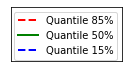

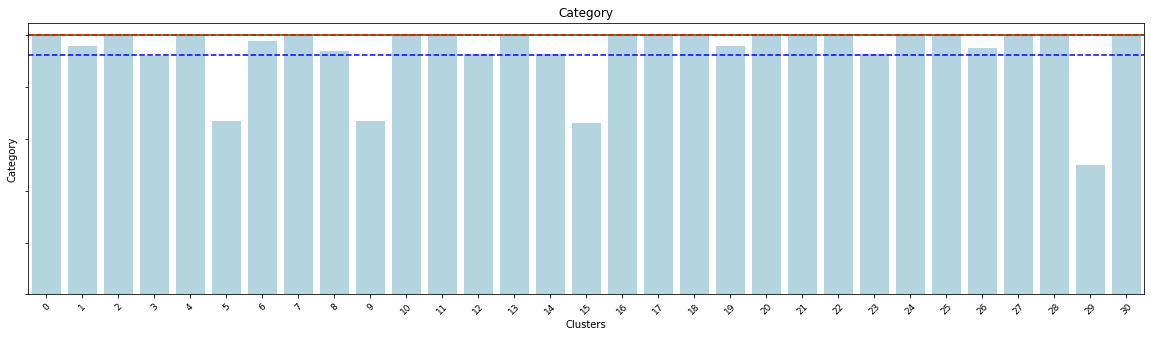

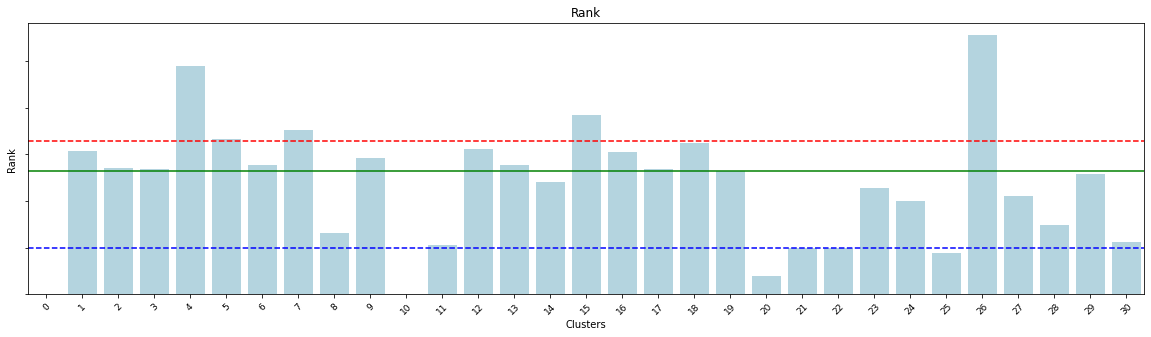

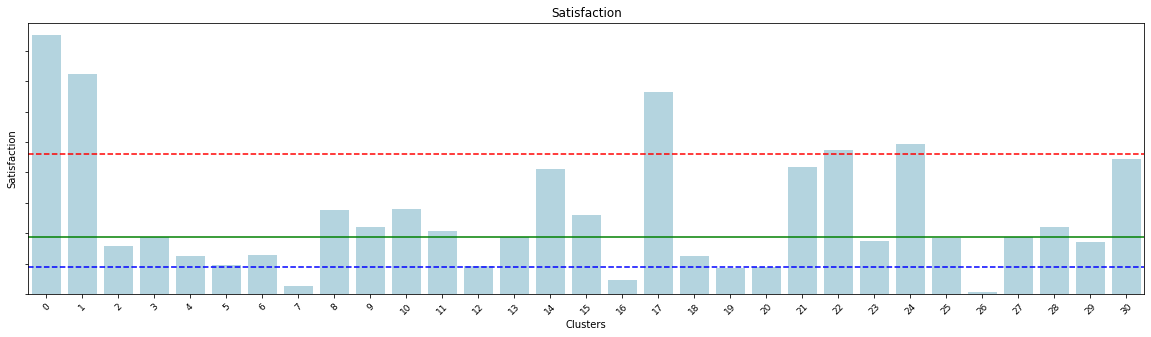

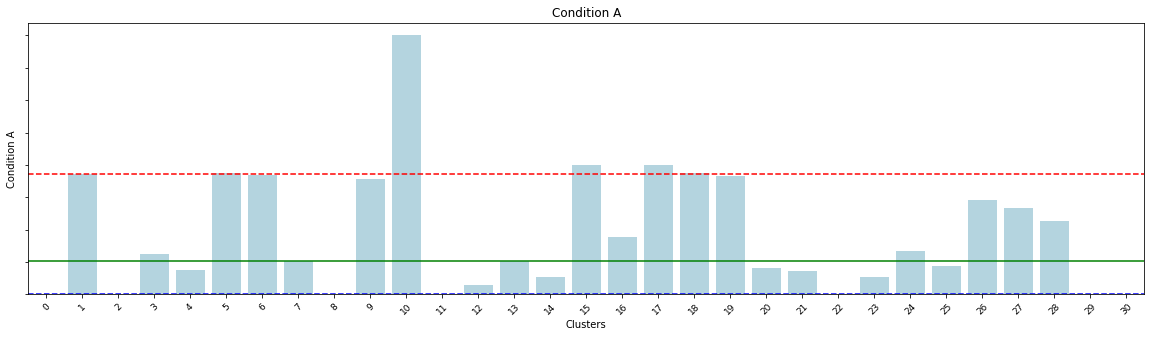

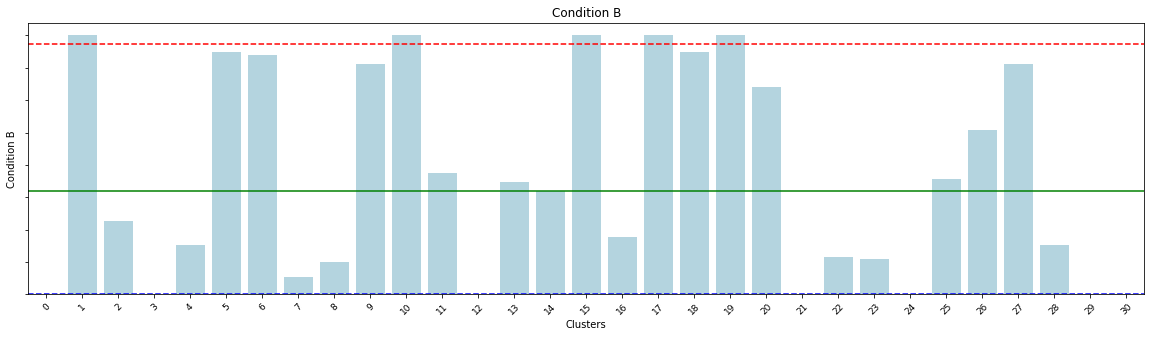

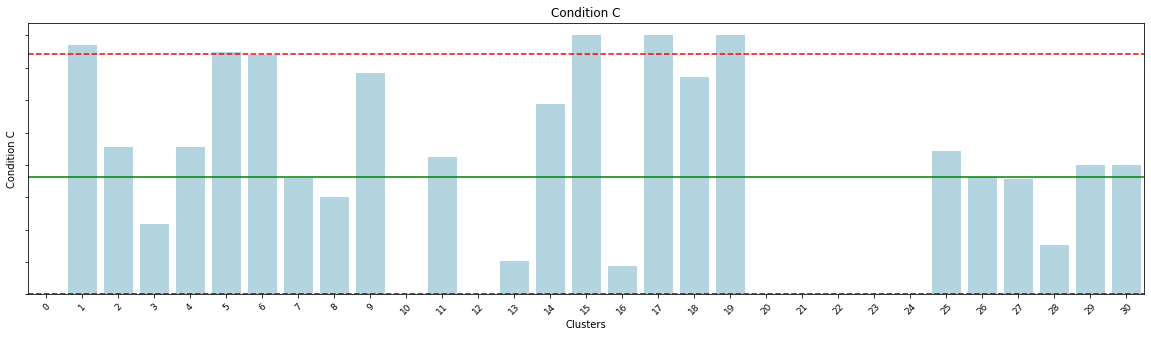

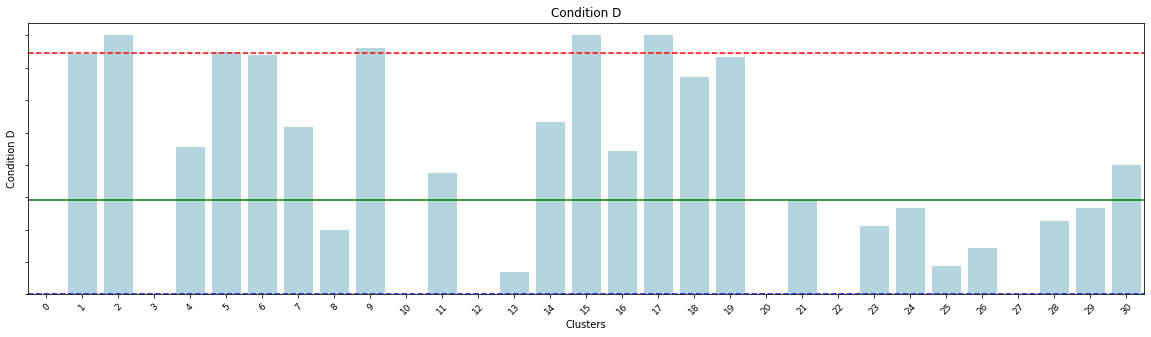

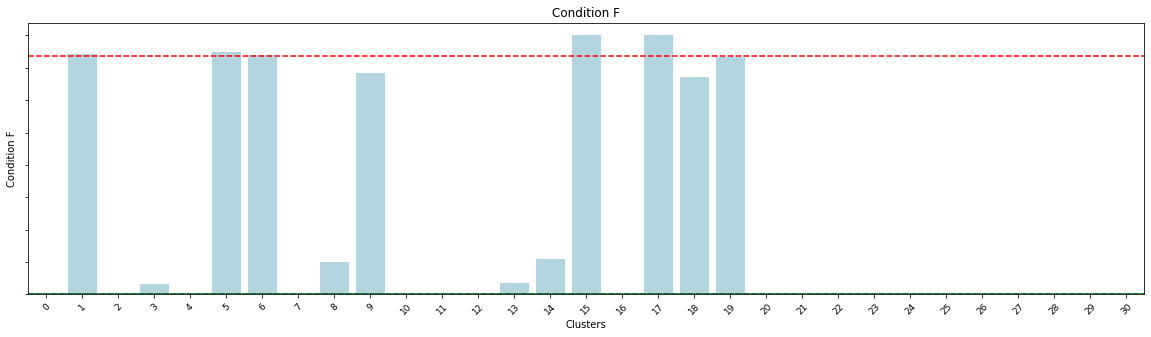

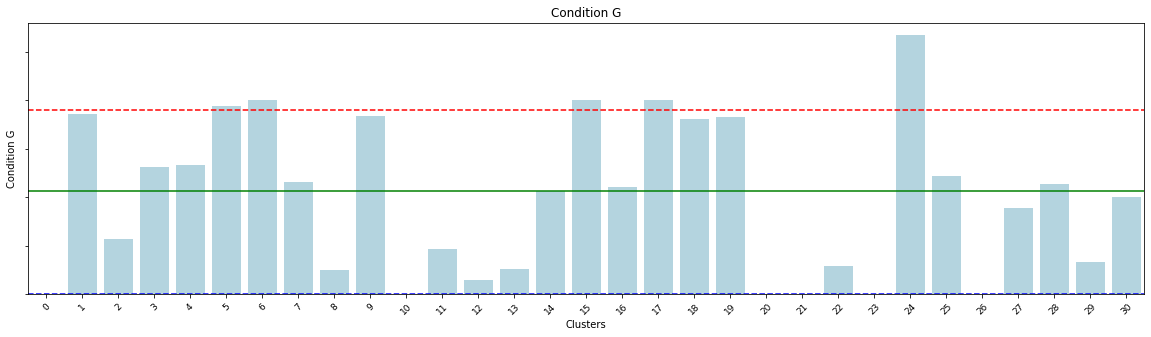

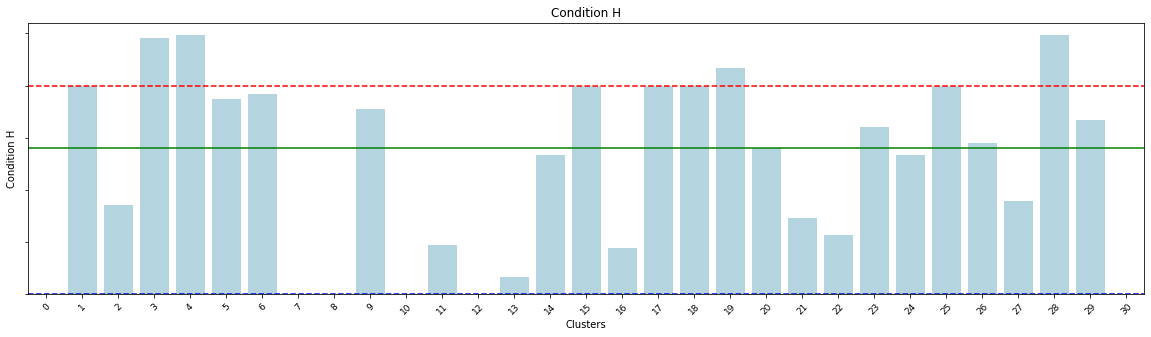

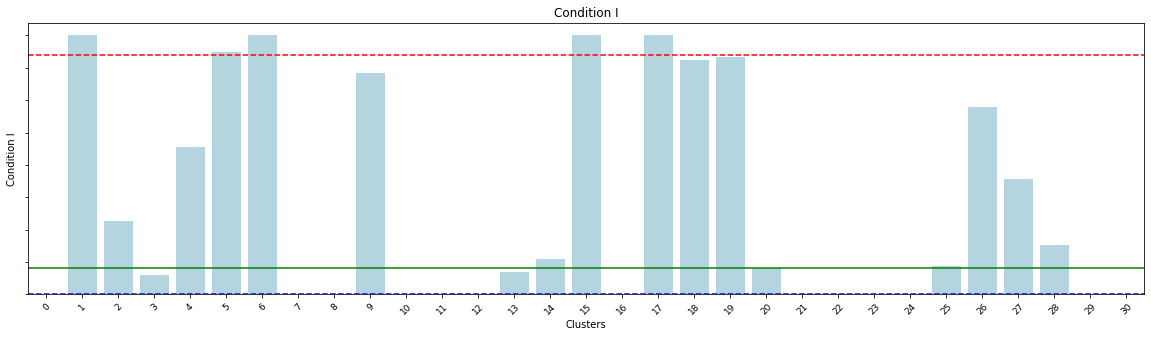

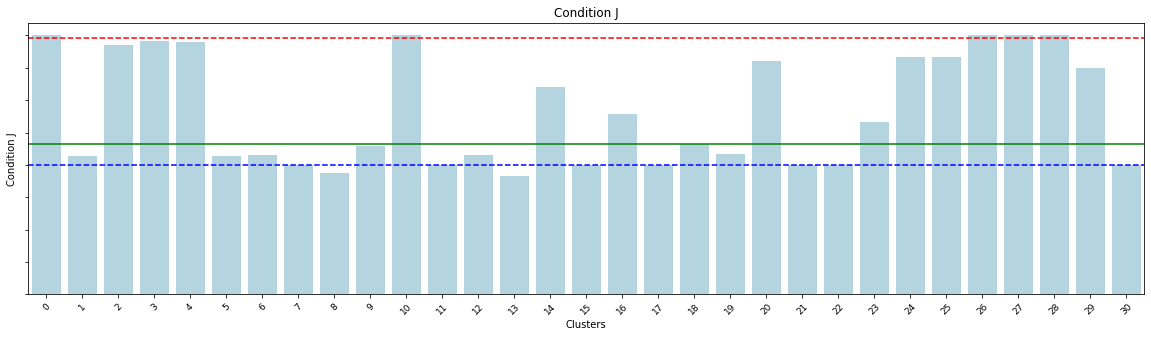

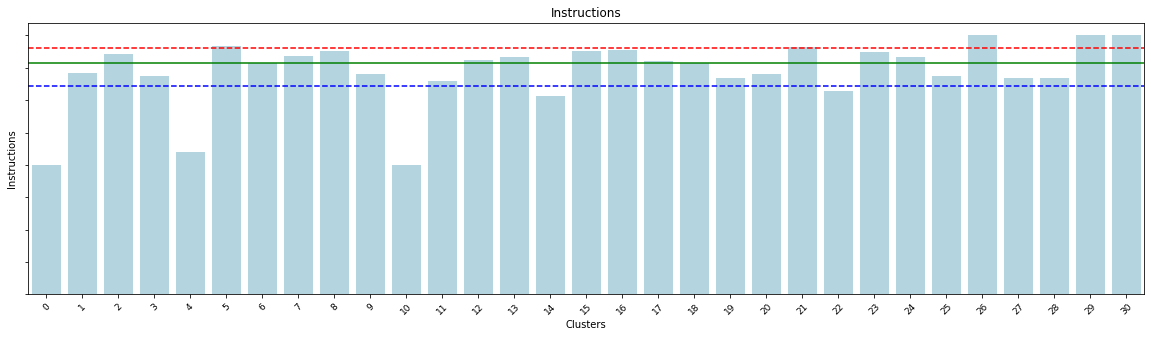

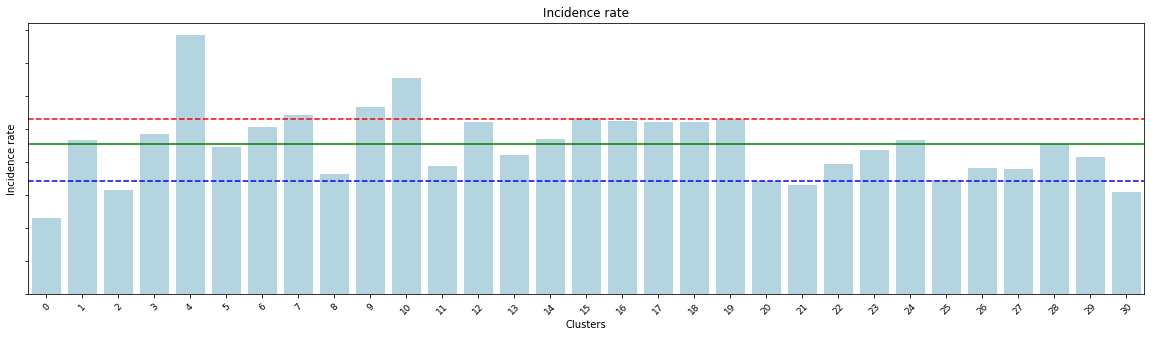

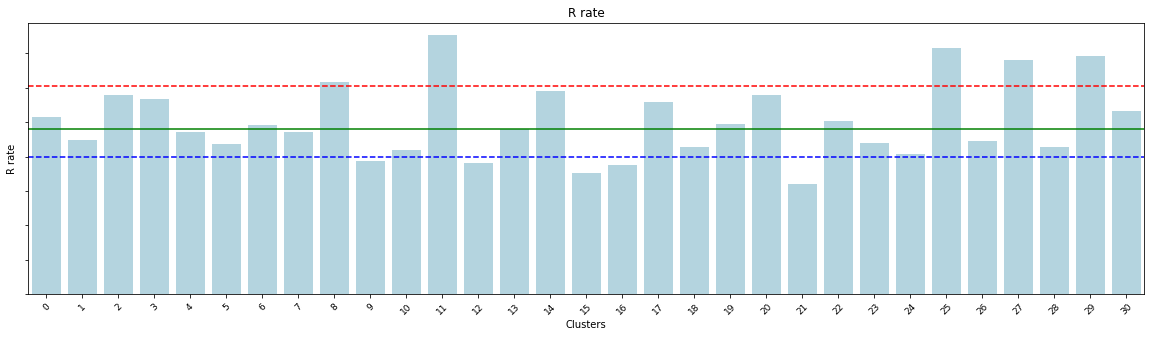

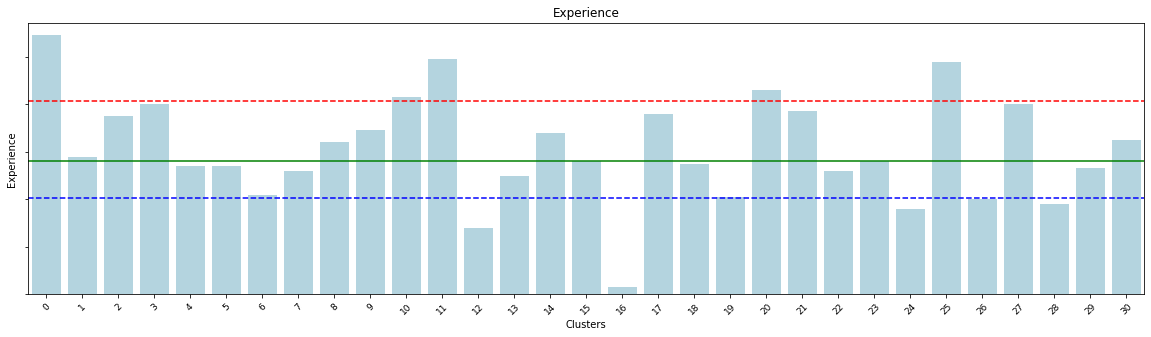

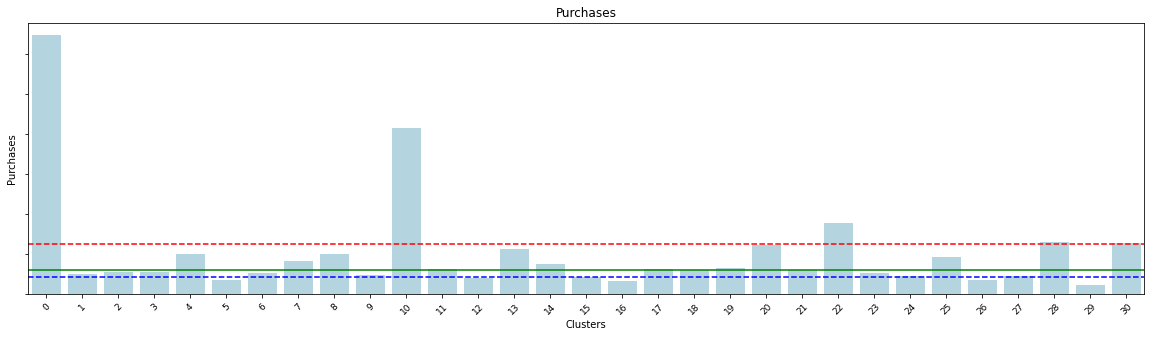

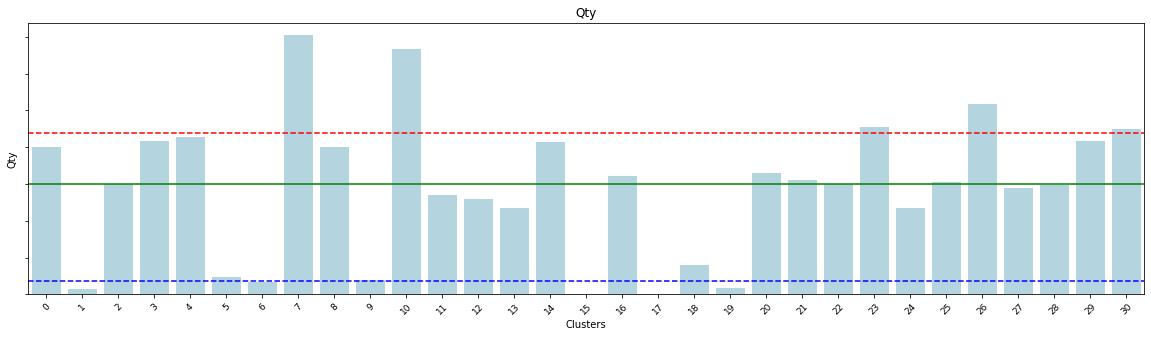

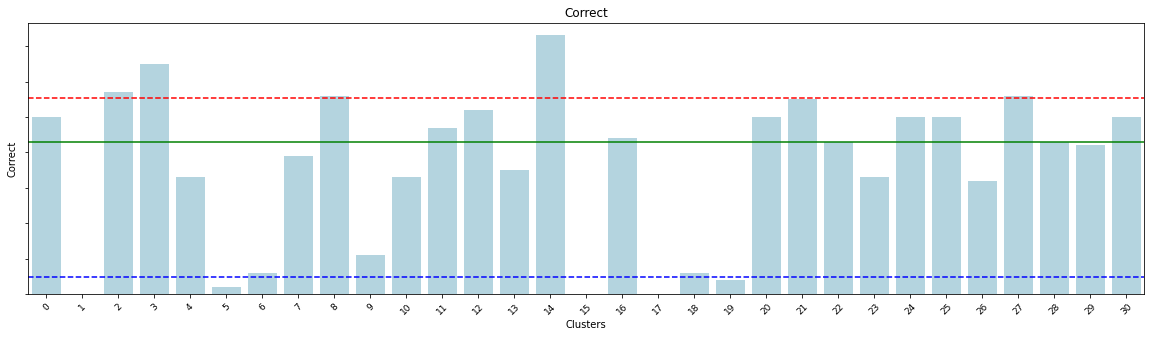

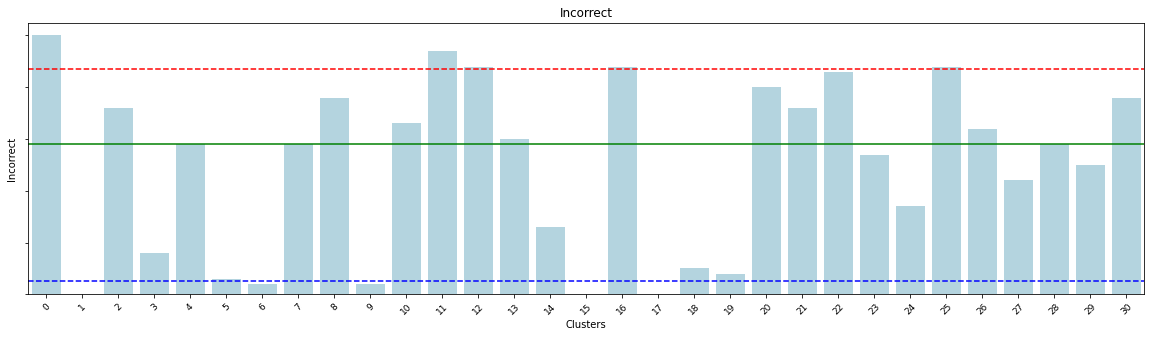

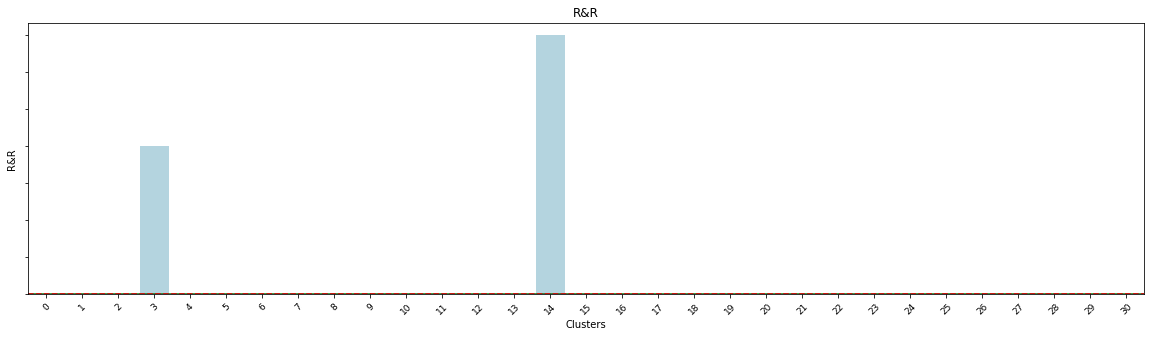

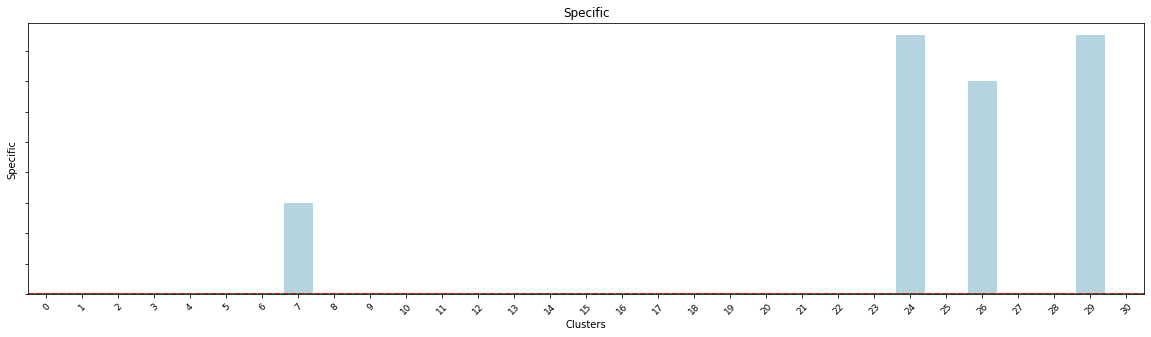

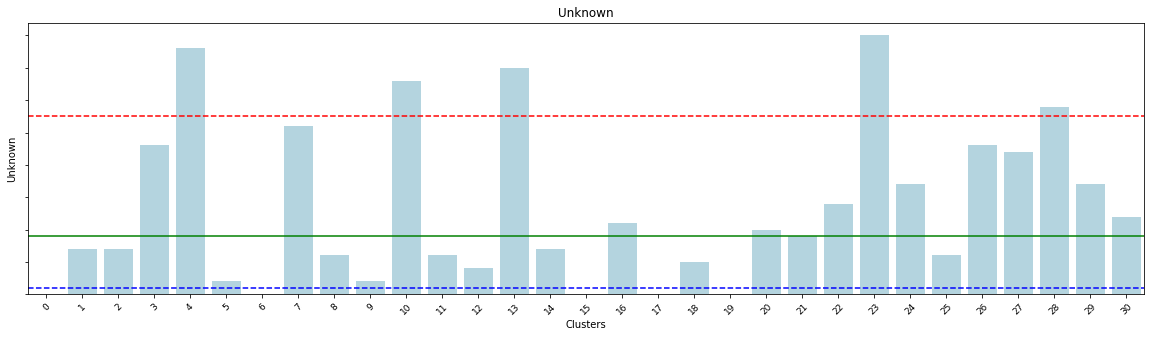

In [27]:
custom_lines = [Line2D([0], [0], color='r', lw=2, ls='--'),
                Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='b', lw=2, ls = '--')]
fig, ax = plt.subplots(figsize=(2,1))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax = plt.legend(custom_lines, ['Quantile 85%', 'Quantile 50%', 'Quantile 15%'], prop={'size': 10})
plt.show()

for column in grouped_clusters_avg.iloc[:,3:6]:
    fig = plt.figure(figsize=(20,5))
    sns.barplot(data=grouped_clusters_avg, x='Clusters', y=column, color='lightblue').set(title=column, yticklabels=[])
    plt.xticks(rotation=45, fontsize=9)
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.15), color = 'b', linestyle = '--')
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.50), color = 'g', linestyle = '-')
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.85), color = 'r', linestyle = '--')
    plt.show()
for column in grouped_clusters_avg.iloc[:,8:]:
    fig = plt.figure(figsize=(20,5))
    sns.barplot(data=grouped_clusters_avg, x='Clusters', y=column, color='lightblue').set(title=column, yticklabels=[])
    plt.xticks(rotation=45, fontsize=9)
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.15), color = 'b', linestyle = '--')
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.50), color = 'g', linestyle = '-')
    plt.axhline(y = np.quantile(grouped_clusters_avg[column], 0.85), color = 'r', linestyle = '--')
    plt.show()

#### 4.3. Selecting bigger clusters.

While 31 clusters is still a lot, let's select the clusters with the most amount of the data within.<br>
We chose to use clusters with more than 35 doctors in each.

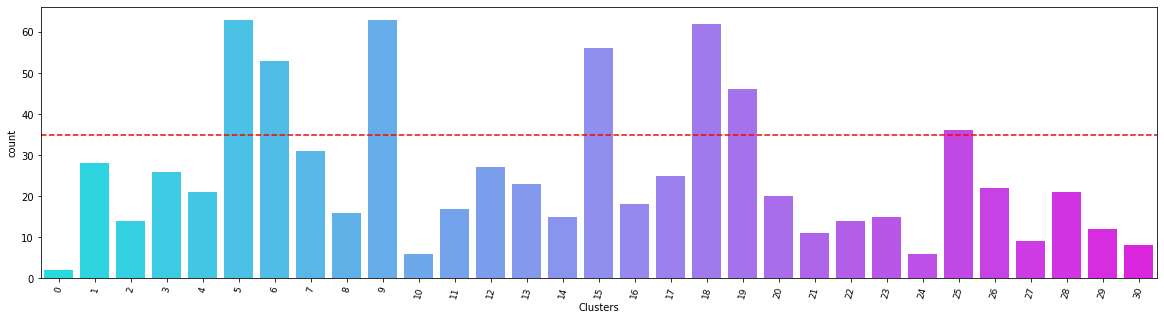

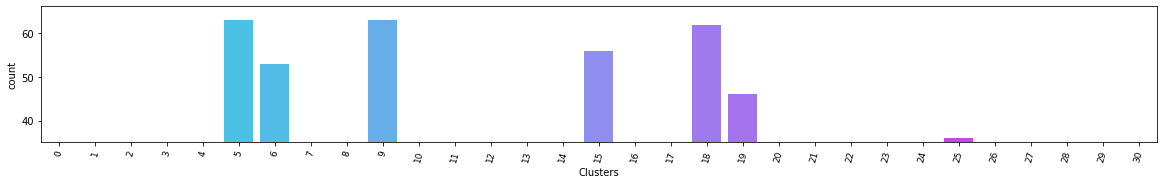

In [28]:
fig = plt.figure(figsize=(20,5))
sns.countplot(kmeans_labels, palette='cool')
plt.xticks(rotation=75, fontsize=9)
plt.axhline(y = 35, color = 'r', linestyle = '--')
plt.xlabel('Clusters')
plt.show()

fig = plt.figure(figsize=(20,2.5))
sns.countplot(kmeans_labels, palette='cool')
plt.xticks(rotation=75, fontsize=9)
plt.ylim(35)
plt.xlabel('Clusters')
plt.show()


In [29]:
grouped_clusters_count = pd.DataFrame(df_enc.value_counts('Clusters').reset_index())
grouped_clusters_count.columns = ['Clusters', 'Count']
clust_chosen = grouped_clusters_count[grouped_clusters_count['Count'] > 35]
clust_chose = clust_chosen['Clusters']

clusters_selected = pd.DataFrame()
for clust_cho in clust_chose:
    cluster = df_enc[df_enc['Clusters'] == clust_cho]
    clusters_selected = clusters_selected.append(cluster)
display(clusters_selected.head())
print("\nThe amount of choosen clusters:", clust_chose.count())
print("The amount of doctors data in the Selected Clusters is:", clusters_selected.shape[0], ", that is", round(clusters_selected.shape[0]/df_enc.shape[0], 4)*100, "% of total amount of provided data\n")

clusters_selected_decoded = pd.DataFrame()
for clust_cho in clust_chose:
    cluster = df_unite[df_unite['Clusters'] == clust_cho]
    clusters_selected_decoded = clusters_selected_decoded.append(cluster)
display(clusters_selected_decoded.head())
print("\nThe amount of choosen clusters:", clust_chose.count())
print("The amount of doctors data in the Selected Clusters is:", clusters_selected_decoded.shape[0], ", that is", round(clusters_selected_decoded.shape[0]/df_enc.shape[0], 4)*100, "% of total amount of provided data\n")

,DoctorID,Region,Category,Rank,Satisfaction,OrderID,OrderNum,Condition A,Condition B,Condition C,...,R rate,Experience,Purchases,Qty,Correct,Incorrect,R&R,Specific,Unknown,Clusters
5,179,0,1,4,17,239,238,2,2,2,...,1.20,0.10,20.0,0.0,0,0,0,0,0,5
33,195,20,1,7,0,239,238,2,2,2,...,0.50,0.17,12.0,0.0,0,0,0,0,0,5
47,188,2,1,4,0,239,238,2,2,2,...,2.82,2.27,11.0,0.0,0,0,0,0,0,5
65,182,3,1,3,66,239,238,2,2,2,...,0.50,0.30,10.0,0.0,0,0,0,0,0,5
106,157,9,1,3,1,239,238,2,2,2,...,0.14,0.71,7.0,0.0,0,0,0,0,0,5



The amount of choosen clusters: 7
The amount of doctors data in the Selected Clusters is: 379 , that is 48.22 % of total amount of provided data



,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases,OrderID,...,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,Complaint Type,Qty,Instructions,Clusters
5,BCJCED,1 10,Specialist,Platinum Plus,19.0,1.20,-50.00,0.10,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
33,BGEEHB,1 8 T3,Specialist,Titanium,12.0,0.50,--,0.17,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
47,BDJHBC,1 11,Specialist,Platinum Plus,10.0,2.82,--,2.27,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
65,BDFCBA,1 12,Specialist,Platinum,9.0,0.50,60.00,0.30,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
106,BADGEJ,1 14,Specialist,Platinum,7.0,0.14,-100.00,0.71,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5



The amount of choosen clusters: 7
The amount of doctors data in the Selected Clusters is: 379 , that is 48.22 % of total amount of provided data



##### 4.3.1. DoctorsID and Purchases per Region in the Selected clusters.

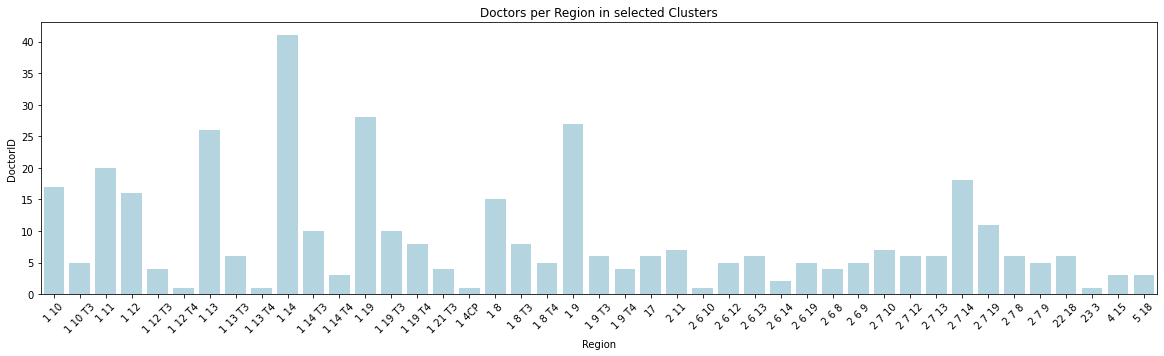

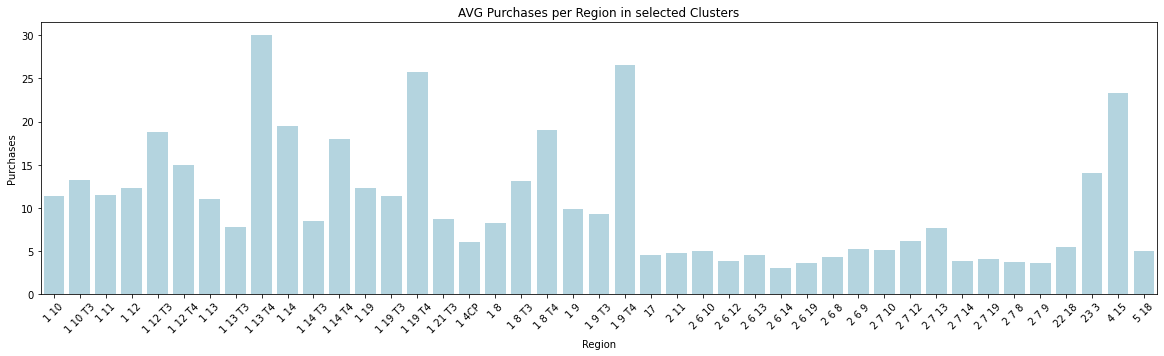

In [30]:
docs_reg_sel = clusters_selected_decoded.groupby('Region')['DoctorID'].count()
docs_reg_sel_df = pd.DataFrame(docs_reg_sel).reset_index()
plt.figure(figsize=(20,5))
sns.barplot(data=docs_reg_sel_df, y='DoctorID', x='Region', color='lightblue').set(title='Doctors per Region in selected Clusters')
plt.xticks(rotation=45)
plt.show()

avg_purch_reg_sel = clusters_selected_decoded.groupby('Region')['Purchases'].mean()
avg_purch_reg_sel_df = pd.DataFrame(avg_purch_reg_sel).reset_index()
plt.figure(figsize=(20,5))
sns.barplot(data=avg_purch_reg_sel_df, y='Purchases', x='Region', color='lightblue').set(title='AVG Purchases per Region in selected Clusters')
plt.xticks(rotation=45)
plt.show()

##### 4.3.2. Selected clusters features.

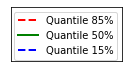

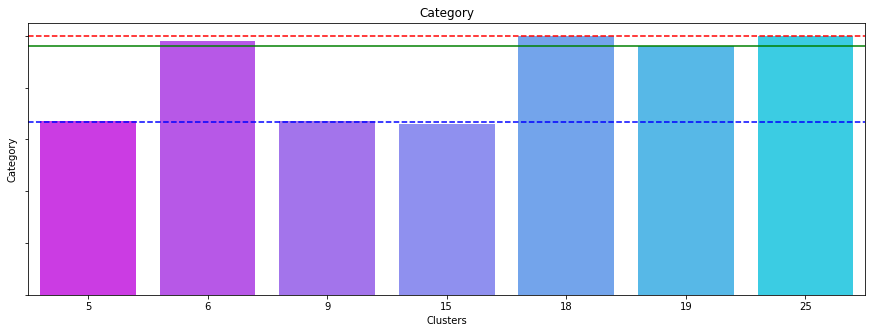

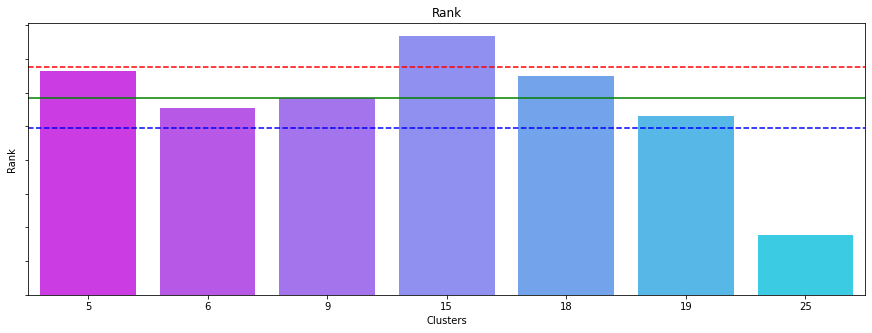

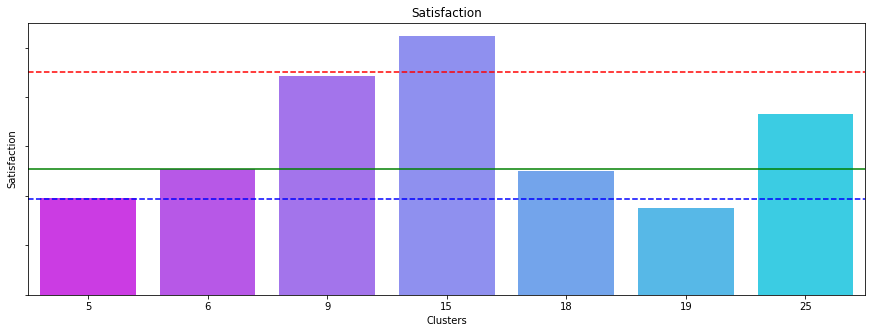

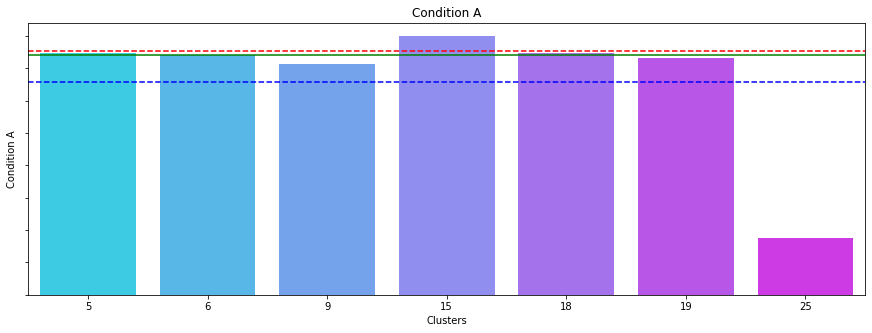

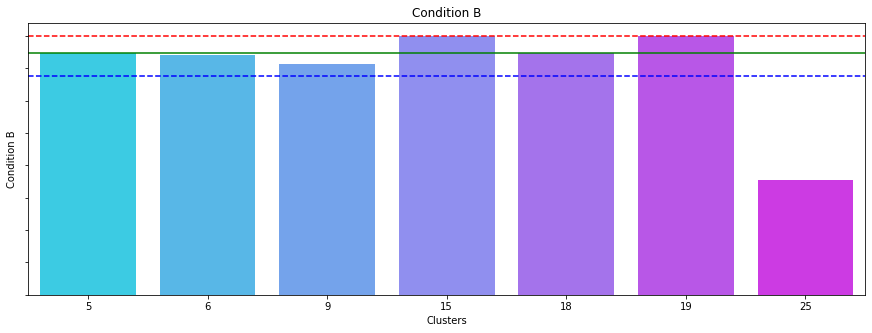

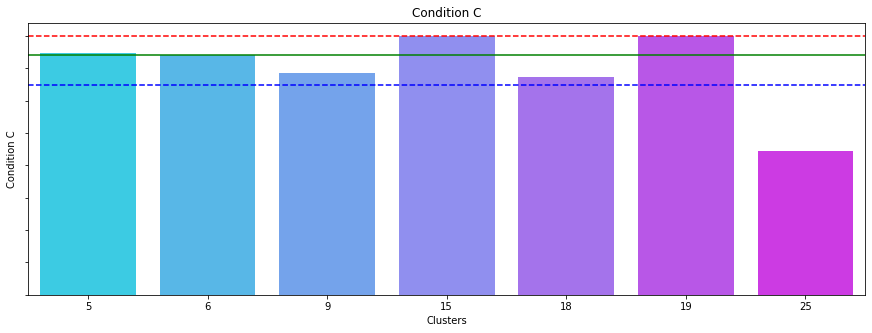

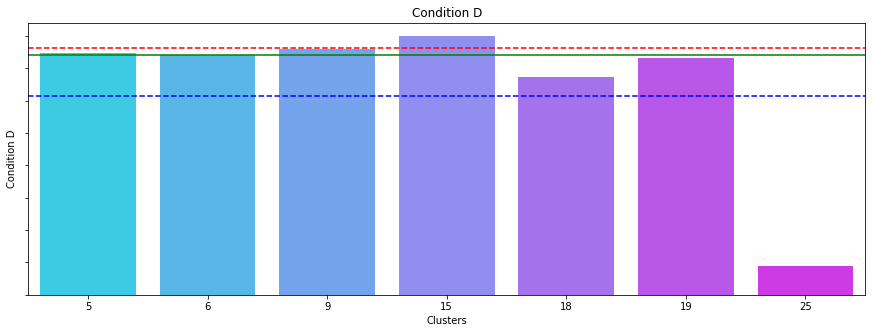

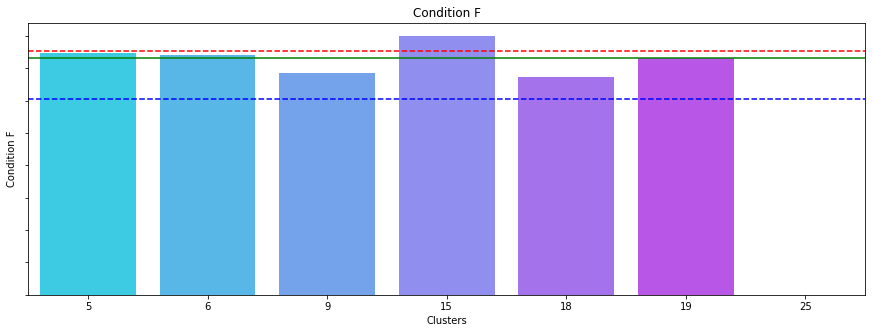

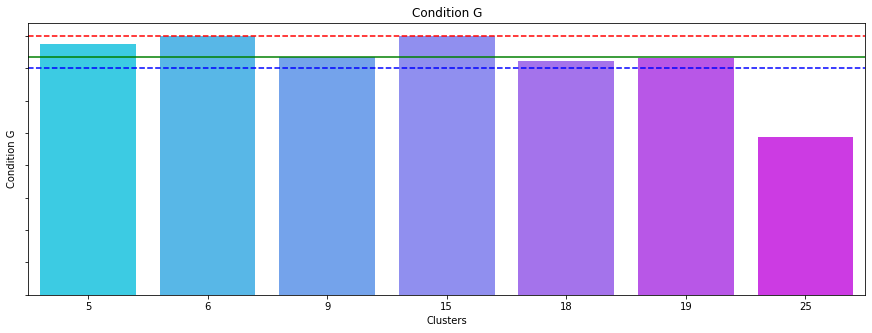

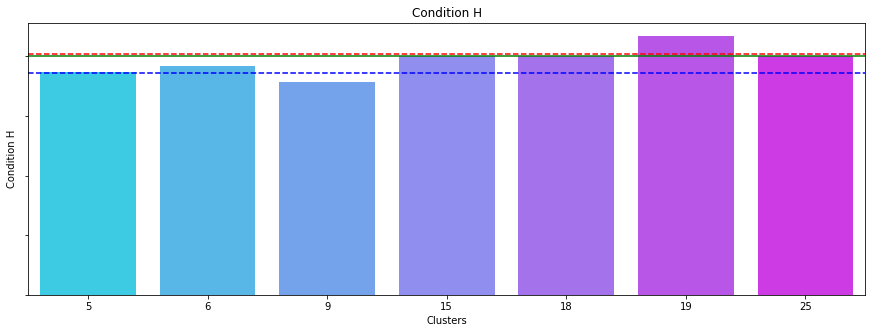

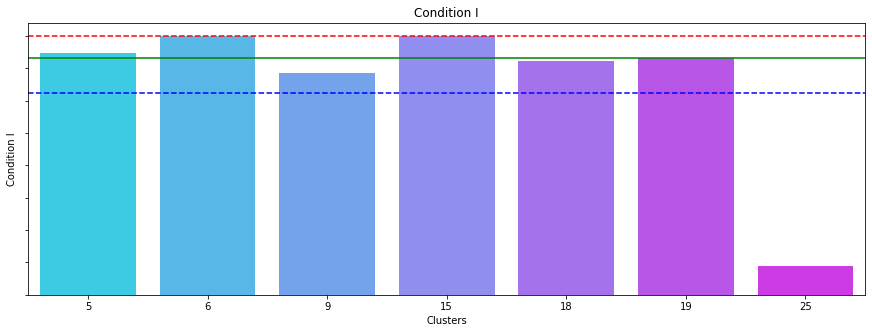

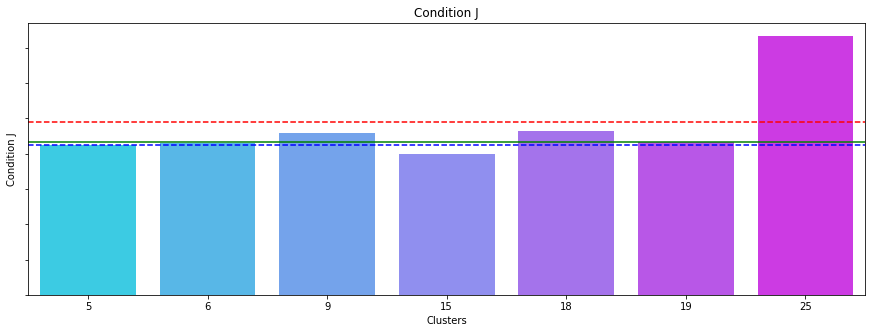

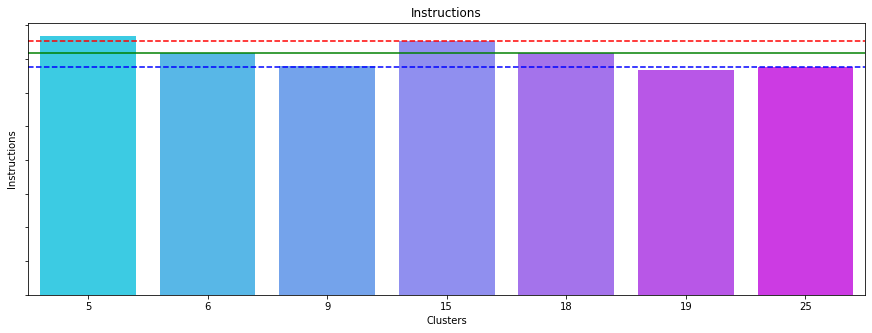

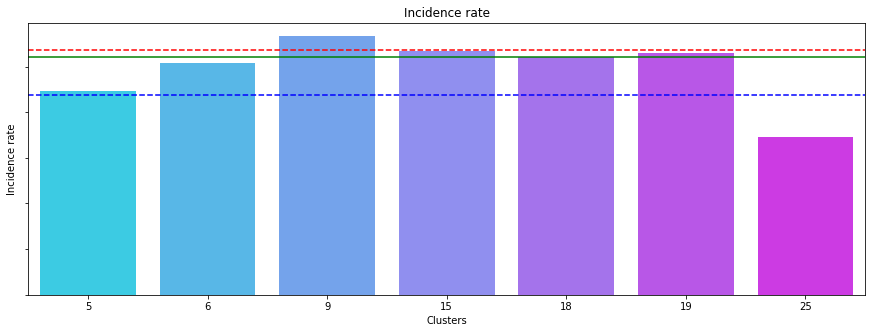

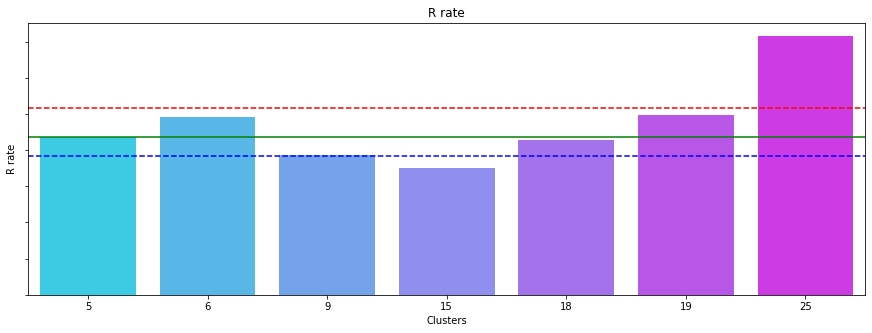

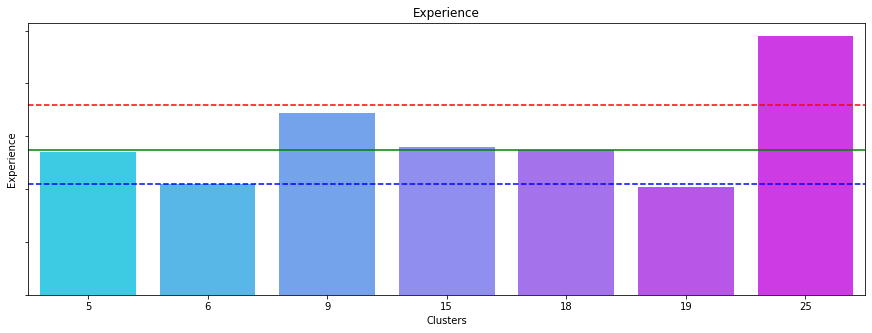

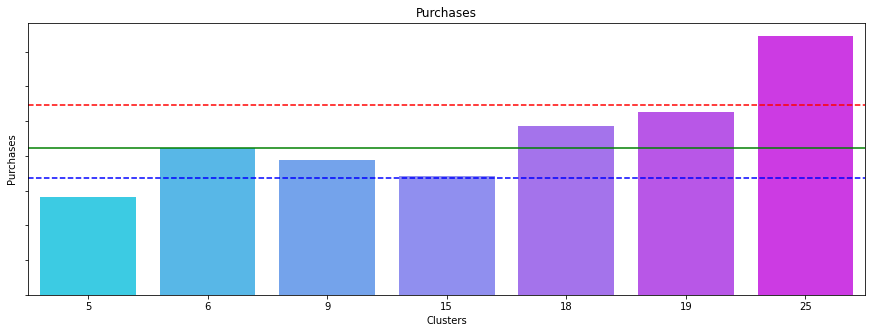

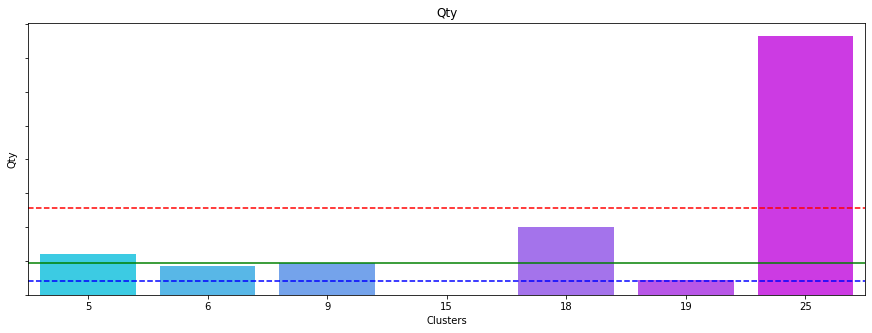

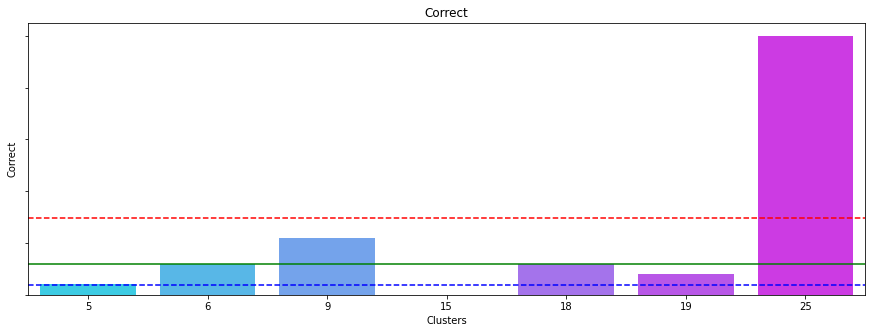

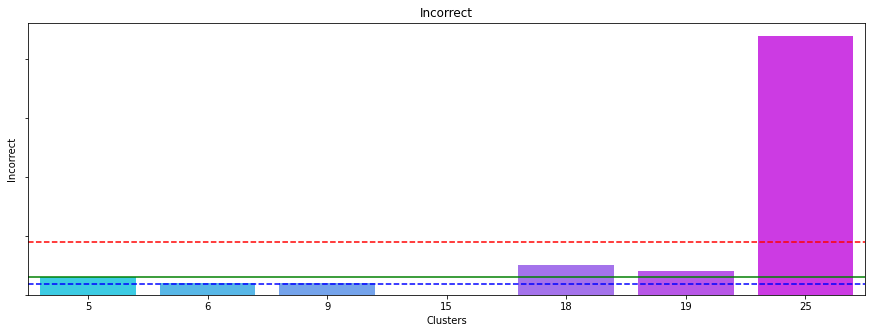

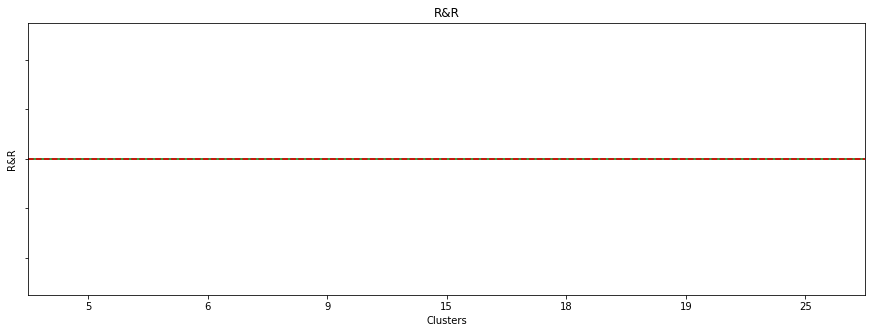

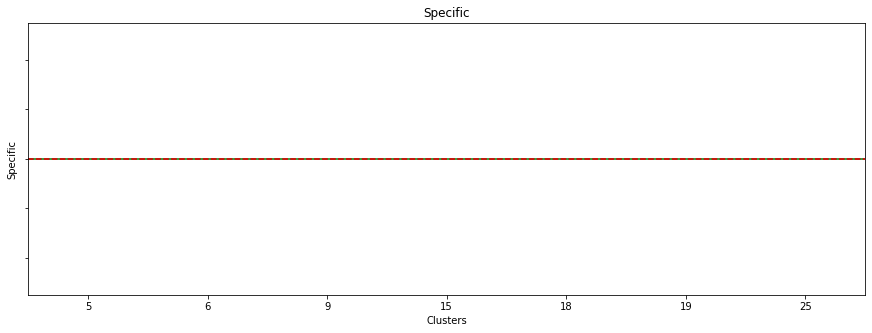

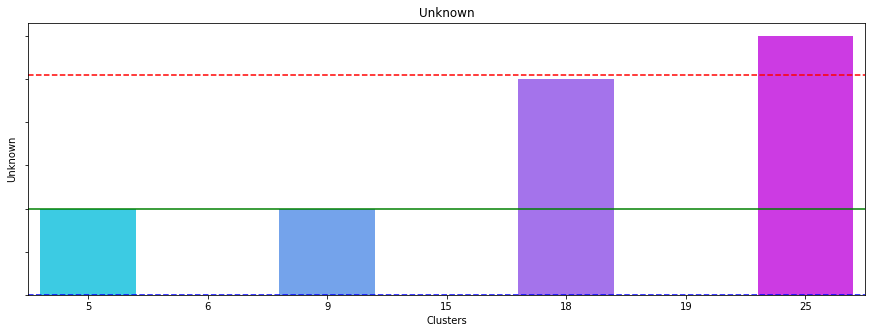

In [31]:
sel_grouped_clusters_avg = clusters_selected.groupby('Clusters').mean().round(2).reset_index()

custom_lines = [Line2D([0], [0], color='r', lw=2, ls='--'),
                Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='b', lw=2, ls = '--')]
fig, ax = plt.subplots(figsize=(2,1))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax = plt.legend(custom_lines, ['Quantile 85%', 'Quantile 50%', 'Quantile 15%'], prop={'size': 10})
plt.show()

for column in sel_grouped_clusters_avg.iloc[:,3:6]:
    fig = plt.figure(figsize=(15,5))
    sns.barplot(data=sel_grouped_clusters_avg, x='Clusters', y=column, palette='cool_r').set(title=column, yticklabels=[])
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.15), color = 'b', linestyle = '--')
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.50), color = 'g', linestyle = '-')
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.85), color = 'r', linestyle = '--')
    plt.show()
for column in sel_grouped_clusters_avg.iloc[:,8:]:
    fig = plt.figure(figsize=(15,5))
    sns.barplot(data=sel_grouped_clusters_avg, x='Clusters', y=column, palette='cool').set(title=column, yticklabels=[])
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.15), color = 'b', linestyle = '--')
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.50), color = 'g', linestyle = '-')
    plt.axhline(y = np.quantile(sel_grouped_clusters_avg[column], 0.85), color = 'r', linestyle = '--')
    plt.show()

## 5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

#### 5.1. Categorisation of the Features of all the Clusters.

In [32]:
operational_df = grouped_clusters_avg.set_index('Clusters').drop(['DoctorID', 'Region', 'OrderID', 'OrderNum'], axis=1).reset_index()

op_df_i = operational_df.iloc[:,1:]

##### 5.1.1. Quantiles per cluster.

In [33]:
quantiles = pd.DataFrame()
for col in op_df_i:
    quantile15 = np.quantile(op_df_i[col], 0.15)
    quantile50 = np.quantile(op_df_i[col], 0.50)
    quantile85 = np.quantile(op_df_i[col], 0.85)
    qua_col = pd.DataFrame([quantile15, quantile50, quantile85]).T
    quantiles = quantiles.append(qua_col)
quantiles = quantiles.T
quantiles.columns = op_df_i.columns
display(quantiles)
display(quantiles.shape)

,Category,Rank,Satisfaction,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,...,Incidence rate,R rate,Experience,Purchases,Qty,Correct,Incorrect,R&R,Specific,Unknown
0,0.925,1.00,9.025,0.000,0.000,0.00,0.000,0.00,0.00,0.0,...,3.440,0.995,0.405,8.445,0.180,0.050,0.025,0.0,0.0,0.010
1,1.000,2.65,18.810,0.520,0.800,0.91,0.730,0.00,1.07,1.4,...,4.550,1.200,0.560,12.360,1.500,0.430,0.290,0.0,0.0,0.090
2,1.000,3.28,45.965,1.865,1.935,1.86,1.865,1.84,1.90,2.0,...,5.315,1.510,0.815,25.075,2.195,0.555,0.435,0.0,0.0,0.275


(3, 23)

##### 5.1.2. Categorization of Clusters Features.

In [63]:
#removing index (features names) for iteration
op_df_i = op_df_i.T
op_df_i = op_df_i.reset_index(drop=True)
op_df_i = op_df_i.T

#Categorisation of Clusters features
outputdf = pd.DataFrame()
for col in op_df_i.iloc[:, range(0, 23)]:
    outputcol = pd.DataFrame()
    for i in op_df_i.iloc[:, col] :
        if i <= quantiles.iloc[0,col] : out = 'Low'
        elif i > quantiles.iloc[0,col] and i < quantiles.iloc[1,col] : out = 'Medium Low'
        elif i > quantiles.iloc[1,col] and i < quantiles.iloc[2,col]: out = 'Medium High'
        elif i >= quantiles.iloc[2,col] : out = 'High'
        elif i == quantiles.iloc[1,col] : out = 'Medium'
        out = pd.Series(out)
        outputcol = outputcol.append(out, ignore_index=True)
    outputdf = outputdf.append(outputcol.T)

In [64]:
# twirl-twist for columns names assign
outputdf = outputdf.T
outputdf.columns = operational_df.iloc[:,1:].columns

outputdf = outputdf.T
clusters_categorised = outputdf.append(operational_df['Clusters'])
clusters_categorised = clusters_categorised.T.set_index('Clusters').reset_index()
display(clusters_categorised.shape)

(31, 24)

In [65]:
#splitting the dataframe for show in three separate dataframes for better observing

conditions_r = clusters_categorised[['Clusters', 'Condition A','Condition B','Condition C','Condition D','Condition F','Condition G','Condition H','Condition I','Condition J']]

complaints = clusters_categorised[['Clusters', 'Correct','Incorrect','R&R','Specific','Unknown']]

another = clusters_categorised.drop(['Condition A','Condition B','Condition C','Condition D','Condition F','Condition G','Condition H','Condition I','Condition J','Correct','Incorrect','R&R','Specific','Unknown'], axis=1)

In [66]:
#coloring clusters features
def clusters_colors(clu):
    if clu == 'Low': bcolor = 'darkblue'
    elif clu == 'Medium Low': bcolor = 'lightblue'
    elif clu == 'Medium High': bcolor = 'lightgreen'
    elif clu == 'High': bcolor = 'green'
    elif clu == 'Medium' : bcolor = 'lightgray'

    return 'background-color: %s' % bcolor

def clusters_colors_font(clu):
    if clu == 'Low': color = 'white'
    elif clu == 'Medium Low': color = 'black'
    elif clu == 'Medium High': color = 'black'
    elif clu == 'High': color = 'white'
    elif clu == 'Medium' : color = 'black'

    return 'color: %s' % color

another_colored = another.set_index('Clusters').style.applymap(clusters_colors).applymap(clusters_colors_font)
complaints_colored = complaints.set_index('Clusters').style.applymap(clusters_colors).applymap(clusters_colors_font)

display(another_colored)
print('\nComplaint Types:')
display(complaints_colored)

,Category,Rank,Satisfaction,Instructions,Incidence rate,R rate,Experience,Purchases,Qty
Clusters,,,,,,,,,
0,High,Low,High,Low,Low,Medium High,High,High,Medium High
1,Medium Low,Medium High,High,Medium Low,Medium High,Medium Low,Medium High,Medium Low,Low
2,High,Medium High,Medium Low,Medium High,Low,Medium High,Medium High,Medium Low,Medium
3,Low,Medium High,Medium,Medium Low,Medium High,Medium High,Medium High,Medium Low,Medium High
4,High,High,Medium Low,Low,High,Medium Low,Medium Low,Medium High,Medium High
5,Low,High,Medium Low,High,Medium Low,Medium Low,Medium Low,Low,Medium Low
6,Medium Low,Medium High,Medium Low,Medium,Medium High,Medium High,Medium Low,Medium Low,Low
7,High,High,Low,Medium High,High,Medium Low,Medium Low,Medium High,High
8,Medium Low,Medium Low,Medium High,Medium High,Medium Low,High,Medium High,Medium High,Medium High



Complaint Types:


,Correct,Incorrect,R&R,Specific,Unknown
Clusters,,,,,
0,Medium High,High,Low,Low,Low
1,Low,Low,Low,Low,Medium Low
2,High,Medium High,Low,Low,Medium Low
3,High,Medium Low,High,Low,Medium High
4,Medium Low,Medium,Low,Low,High
5,Low,Medium Low,Low,Low,Medium Low
6,Medium Low,Low,Low,Low,Low
7,Medium Low,Medium,Low,High,Medium High
8,High,Medium High,Low,Low,Medium Low


In [70]:
conditions_r = conditions_r.replace(['High', 'Low', 'Medium High', 'Medium Low', 'Medium'], 
                                ['True', 'False', 'Closer to True', 'Closer to False', 'NaN'])

def clusters_colors_c(clu):
    global bcolor_c
    if clu == 'True': bcolor_c = 'green'
    elif clu == 'Closer to False': bcolor_c = 'lightblue'
    elif clu == 'False': bcolor_c = 'darkblue'
    elif clu == 'Closer to True': bcolor_c = 'lightgreen'
    elif clu == 'NaN' : bcolor_c = 'gray'

    return 'background-color: %s' % bcolor_c

def clusters_colors_font_c(clu):
    global color_c
    if clu == 'True': color_c = 'white'
    elif clu == 'Closer to False': color_c = 'black'
    elif clu == 'False': color_c = 'white'
    elif clu == 'Closer to True': color_c = 'black'
    elif clu == 'NaN' : color_c = 'white'

    return 'color: %s' % color_c


conditions_r_colored = conditions_r.set_index('Clusters').style.applymap(clusters_colors_c).applymap(clusters_colors_font_c)
print('\nConditionss:')
display(conditions_r_colored)


Conditionss:


,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
Clusters,,,,,,,,,
0,False,False,False,False,False,False,False,False,True
1,Closer to True,True,True,Closer to True,True,Closer to True,True,True,Closer to False
2,False,Closer to False,Closer to True,True,False,Closer to False,Closer to False,Closer to True,Closer to True
3,Closer to True,False,Closer to False,False,Closer to True,Closer to True,True,Closer to False,Closer to True
4,Closer to False,Closer to False,Closer to True,Closer to True,False,Closer to True,True,Closer to True,Closer to True
5,True,Closer to True,True,True,True,True,Closer to True,True,Closer to False
6,Closer to True,Closer to True,Closer to True,Closer to True,True,True,Closer to True,True,Closer to False
7,NaN,Closer to False,Closer to False,Closer to True,False,Closer to True,False,False,False
8,False,Closer to False,Closer to False,Closer to False,Closer to True,Closer to False,False,False,False


#### 5.2. Categorization of the Features of all the Selected Clusters.

In [39]:
sel_operational_df = sel_grouped_clusters_avg.set_index('Clusters').drop(['DoctorID', 'Region', 'OrderID', 'OrderNum'], axis=1).reset_index()

sel_op_df_i = sel_operational_df.iloc[:,1:]
display(sel_op_df_i.shape)

(7, 23)

##### 5.1.1. Quantiles per cluster.
The Quantiles for the Selected Clusters are the separate entity from the quantiles computed before, because based on the data existed in the Selected Clusters only.

In [40]:
sel_quantiles = pd.DataFrame()
for col in sel_op_df_i:
    quantile25 = np.quantile(sel_op_df_i[col], 0.25)
    quantile50 = np.quantile(sel_op_df_i[col], 0.50)
    quantile95 = np.quantile(sel_op_df_i[col], 0.95)
    sel_qua_col = pd.DataFrame([quantile25, quantile50, quantile95]).T
    sel_quantiles = sel_quantiles.append(sel_qua_col)
sel_quantiles = sel_quantiles.T
sel_quantiles.columns = sel_op_df_i.columns
display(sel_quantiles)
display(sel_quantiles.shape)

,Category,Rank,Satisfaction,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,...,Incidence rate,R rate,Experience,Purchases,Qty,Correct,Incorrect,R&R,Specific,Unknown
0,0.67,2.710,11.170,1.805,1.815,1.695,1.755,1.695,1.82,1.895,...,4.775,1.020,0.480,9.145,0.130,0.030,0.020,0.0,0.0,0.000
1,0.96,2.920,12.770,1.850,1.870,1.850,1.850,1.830,1.84,2.000,...,5.210,1.090,0.550,10.550,0.190,0.060,0.030,0.0,0.0,0.020
2,1.00,3.684,24.965,1.961,2.000,2.000,1.970,1.961,2.00,2.119,...,5.568,1.625,0.893,16.987,1.191,0.383,0.323,0.0,0.0,0.057


(3, 23)

##### 5.1.2. Categorisation of the Selected Clusters Features.

In [77]:
#removing index (features names) for iteration
sel_op_df_i = sel_op_df_i.T
sel_op_df_i = sel_op_df_i.reset_index(drop=True)
sel_op_df_i = sel_op_df_i.T

#Categorisation of Clusters features
sel_outputdf = pd.DataFrame()
for col in sel_op_df_i.iloc[:, range(0, 23)]:
    sel_outputcol = pd.DataFrame()
    for i in sel_op_df_i.iloc[:, col] :
        if i <= sel_quantiles.iloc[0,col] : sel_out = 'Low'
        elif i > sel_quantiles.iloc[0,col] and i < sel_quantiles.iloc[1,col] : sel_out = 'Medium Low'
        elif i > sel_quantiles.iloc[1,col] and i < sel_quantiles.iloc[2,col]: sel_out = 'Medium High'
        elif i >= sel_quantiles.iloc[2,col] : sel_out = 'High'
        elif i == sel_quantiles.iloc[1,col] : sel_out = 'Medium'
        sel_out = pd.Series(sel_out)
        sel_outputcol = sel_outputcol.append(sel_out, ignore_index=True)
    sel_outputdf = sel_outputdf.append(sel_outputcol.T)

In [78]:
# twirl-twist for columns names assign
sel_outputdf = sel_outputdf.T
sel_outputdf.columns = sel_operational_df.iloc[:,1:].columns

sel_outputdf = sel_outputdf.T
sel_clusters_categorised = sel_outputdf.append(sel_operational_df['Clusters'])
sel_clusters_categorised = sel_clusters_categorised.T.set_index('Clusters').reset_index()
#display(sel_clusters_categorised.shape)

In [79]:
#splitting the dataframe for show in three separate dataframes for better observing

sel_conditions = sel_clusters_categorised[['Clusters', 'Condition A','Condition B','Condition C','Condition D','Condition F','Condition G','Condition H','Condition I','Condition J']]

sel_complaints = sel_clusters_categorised[['Clusters', 'Correct','Incorrect','R&R','Specific','Unknown']]

sel_another = sel_clusters_categorised.drop(['Condition A','Condition B','Condition C','Condition D','Condition F','Condition G','Condition H','Condition I','Condition J','Correct','Incorrect','R&R','Specific','Unknown'], axis=1)

In [80]:
#coloring clusters features
def clusters_colors(clu):
    if clu == 'Low': bcolor = 'darkblue'
    elif clu == 'Medium Low': bcolor = 'lightblue'
    elif clu == 'Medium High': bcolor = 'lightgreen'
    elif clu == 'High': bcolor = 'green'
    elif clu == 'Medium': bcolor = 'lightgray'

    return 'background-color: %s' % bcolor

def clusters_colors_font(clu):
    if clu == 'Low': color = 'white'
    elif clu == 'Medium Low': color = 'black'
    elif clu == 'Medium High': color = 'black'
    elif clu == 'High': color = 'white'
    elif clu == 'Medium': color = 'black'

    return 'color: %s' % color

sel_another_colored = sel_another.set_index('Clusters').style.applymap(clusters_colors).applymap(clusters_colors_font)
sel_complaints_colored = sel_complaints.set_index('Clusters').style.applymap(clusters_colors).applymap(clusters_colors_font)

display(sel_another_colored)
print('\nComplaint Types:')
display(sel_complaints_colored)

,Category,Rank,Satisfaction,Instructions,Incidence rate,R rate,Experience,Purchases,Qty
Clusters,,,,,,,,,
5,Low,Medium High,Low,High,Low,Medium,Medium Low,Low,Medium High
6,Medium High,Medium Low,Medium,Medium,Medium Low,Medium High,Low,Medium,Medium Low
9,Low,Medium,Medium High,Medium Low,High,Low,Medium High,Medium Low,Medium
15,Low,High,High,Medium High,Medium High,Low,Medium High,Low,Low
18,High,Medium High,Medium Low,Medium,Medium,Medium Low,Medium,Medium High,Medium High
19,Medium,Low,Low,Low,Medium High,Medium High,Low,Medium High,Low
25,High,Low,Medium High,Low,Low,High,High,High,High



Complaint Types:


,Correct,Incorrect,R&R,Specific,Unknown
Clusters,,,,,
5,Low,Medium,Low,Low,Medium
6,Medium,Low,Low,Low,Low
9,Medium High,Low,Low,Low,Medium
15,Low,Low,Low,Low,Low
18,Medium,Medium High,Low,Low,Medium High
19,Medium Low,Medium High,Low,Low,Low
25,High,High,Low,Low,High


In [81]:
sel_conditions = sel_conditions.replace(['High', 'Low', 'Medium High', 'Medium Low', 'Medium'], 
                                        ['True', 'False', 'Closer to True', 'Closer to False', 'NaN'])

def clusters_colors_c(clu):
    global bcolor_c
    if clu == 'True': bcolor_c = 'green'
    elif clu == 'Closer to False': bcolor_c = 'lightblue'
    elif clu == 'False': bcolor_c = 'darkblue'
    elif clu == 'Closer to True': bcolor_c = 'lightgreen'
    elif clu == 'NaN': bcolor_c = 'gray'

    return 'background-color: %s' % bcolor_c

def clusters_colors_font_c(clu):
    global color_c
    if clu == 'True': color_c = 'white'
    elif clu == 'Closer to False': color_c = 'black'
    elif clu == 'False': color_c = 'white'
    elif clu == 'Closer to True': color_c = 'black'
    elif clu == 'NaN': color_c = 'white'

    return 'color: %s' % color_c


sel_conditions_colored = sel_conditions.set_index('Clusters').style.applymap(clusters_colors_c).applymap(clusters_colors_font_c)
print('Conditions:')
display(sel_conditions_colored)

Conditions:


,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
Clusters,,,,,,,,,
5,Closer to True,NaN,Closer to True,Closer to True,Closer to True,Closer to True,False,Closer to True,False
6,NaN,Closer to False,NaN,NaN,Closer to True,True,Closer to False,True,Closer to False
9,False,False,Closer to False,Closer to True,Closer to False,NaN,False,False,Closer to True
15,True,True,True,True,True,True,NaN,True,False
18,Closer to True,NaN,False,False,False,False,NaN,Closer to False,Closer to True
19,Closer to False,True,True,Closer to False,NaN,Closer to False,True,NaN,NaN
25,False,False,False,False,False,False,NaN,False,True


#### 5.3. Description.
All you need for description of the new clusters you can see in the colored frames above.<br>
For example Clusters <b>0</b>, <b>10</b>, <b>22</b>, <b>28</b> and <b>30</b> have <b>High Purchases</b>. But all of them are below 35 doctors in each. <br>
<b>Cluster 25</b> in compare within selected clusters, which have more than 35 doctors in each, have the <b>High Purchases</b>, <b>Experience</b>, <b>Qty</b>, and <b>R-rate</b> and <b>Low Incidence rate</b> an <b>Instructions</b>. This cluster also are describable by <b>High</b> amount of the <b>Correct</b>, <b>Unknown</b> and <b>Incorrect Complaints</b>, and by <b>False</b> in most of the <b>Conditions</b>.<br>
<b>Clusters 5</b>, <b>26</b> and <b>29</b> are <b>Low Purchases</b> and <b>High Instructions</b> clusters. The <b>5</b> are included in the <b>Selected</b> clusters (have more than 35 doctors) and also have <b>Low</b> value of <b>Correct Complaints</b>.

### 6. Conclusions.

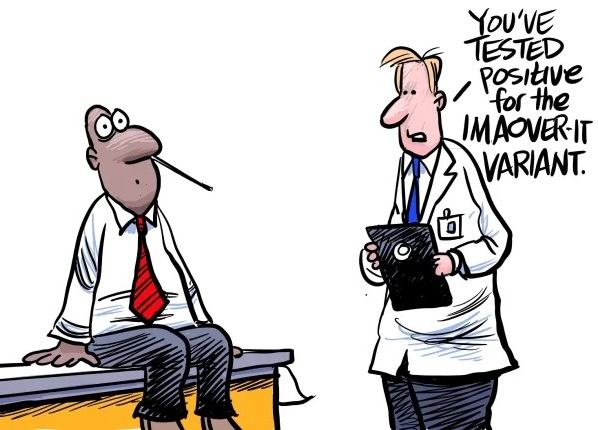

In [46]:
Image(filename='images/imaoverit.jpg', width=600 , height=600 )